In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib as mpl
from matplotlib.patches import Patch
import scienceplots
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm
from scipy.spatial.distance import jensenshannon
# import pymc as pm
# import aesara.tensor as at
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# import arviz as az
# import pytensor.tensor as at

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

COLORS = [ "#bfef45","#3cb44b","#42d4f4","#4363d8","#911eb4","#f032e6","#a9a9a9","#fabed4","#ffd8b1","#fffac8","#aaffc3",
          "#dcbeff", "#800000","#9A6324","#808000","#469990","#000075","#000000","#e6194B","#f58231","#ffe119",
         ]

MARKERS = ["o", "^", "s", "P", "o", "X", "^", "v"]
LINESTYLES = ["solid", "dashed", "dashdot", "dotted"]

mpl.rcParams["hatch.linewidth"] = 0.7
mpl.rcParams.update(mpl.rcParamsDefault)


# Main Analysis: Preprocess Data

In [2]:
ball_comp = {(2,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.3, 'p_col2_u2':0.7}, 
             (2,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.2, 'p_col2_u2':0.1, 'p_col3_u2':0.7},
             (2,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.2, 'p_col3_u2':0.3, 'p_col4_u2':0.4},
             (3,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.5, 'p_col2_u2':0.5, 'p_col1_u3':0.3, 'p_col2_u3':0.7},
             (3,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.7, 'p_col3_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.7},
             (3,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.3, 'p_col2_u2':0.2, 'p_col3_u2':0.2, 'p_col4_u2':0.3, 'p_col1_u3':0.1, 'p_col2_u3':0.2, 'p_col3_u3':0.3, 'p_col4_u3':0.4},
             (4,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.6, 'p_col2_u2':0.4, 'p_col1_u3':0.4, 'p_col2_u3':0.6, 'p_col1_u4':0.3, 'p_col2_u4':0.7},
             (4,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.7, 'p_col3_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.7, 'p_col1_u4':0.3, 'p_col2_u4':0.4, 'p_col3_u4':0.3},
             (4,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.3, 'p_col2_u2':0.4, 'p_col3_u2':0.1, 'p_col4_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.4, 'p_col4_u3':0.3, 'p_col1_u4':0.1, 'p_col2_u4':0.2, 'p_col3_u4':0.3, 'p_col4_u4':0.4}
}

## Read Data

In [3]:
def read_participant_data(filePath, min_pID, max_pID, insList):
    ''''
    Reads participant data main experiment data from JSON files and combines them into a single DataFrame.
    '''
    participantsWithData = []
    for pID in range(min_pID, max_pID+1):
        completed = True
        for instance_name in insList:
            try:
                with open(filePath + f'participantData{pID}/p{pID}BU{instance_name}.json') as f:
                    data = json.load(f)
                    df = pd.json_normalize(data)
                    if 'participant_data' not in locals():
                        participant_data = df
                    else:
                        participant_data = pd.concat([participant_data, df], ignore_index=True)
                
            except FileNotFoundError:
                completed = False
                
        if completed:
            participantsWithData.append(pID)

    print(f'Participants with complete data: {participantsWithData}')
    incomplete_data_participants = [pID for pID in participant_data["participantID"].unique() if int(pID) not in participantsWithData]
    print(f'Participants with incomplete data: {incomplete_data_participants}')
    return participant_data, incomplete_data_participants

In [4]:
# Read participant data from json
min_pID = 1
max_pID = 118
insList = [1,3,5,7,9,11,12,13,15,16,17,18]
filePath = '../participantData/'

participant_data, incomplete_lis = read_participant_data(filePath, min_pID, max_pID, insList)

Participants with complete data: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 75, 77, 79, 80, 81, 82, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118]
Participants with incomplete data: ['2345', '1576998']


### Participant ID correction
correct all the pID that participants entered wrongly

In [5]:
print(participant_data['participantID'].unique())
participant_data['participantID'] = participant_data['participantID'].replace({'2345': '22', '1576998': '38'})
print(participant_data['participantID'].unique())


['1' '2' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16' '17'
 '18' '19' '20' '21' '2345' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '37' '1576998' '39' '40' '41' '42' '44' '46' '47'
 '49' '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62'
 '63' '64' '65' '66' '67' '68' '69' '71' '72' '73' '75' '77' '79' '80'
 '81' '82' '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97'
 '98' '99' '100' '101' '102' '103' '104' '105' '106' '107' '108' '109'
 '110' '112' '113' '114' '115' '116' '117' '118']
['1' '2' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16' '17'
 '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '37' '38' '39' '40' '41' '42' '44' '46' '47' '49'
 '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62' '63'
 '64' '65' '66' '67' '68' '69' '71' '72' '73' '75' '77' '79' '80' '81'
 '82' '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98'
 '99' '100' '101' '10

### change participant ID data type to int

In [6]:
participant_data['participantID'] = participant_data['participantID'].astype(int)

### Read the Demographic Data - Combine with main data

In [7]:
def read_demographic_data(filePath, min_pID, max_pID):
    '''
    Reads demographic data from CSV files and combines them into a single DataFrame.
    '''
    demo_df = pd.DataFrame()
    for pID in range(min_pID, max_pID+1):
        try:
            df = pd.read_csv(filePath + f'participantData{pID}/demographicData/p{pID}.csv')
            demo_df = pd.concat([demo_df, df[['participantID','payID','fullName','age','sex','probSubject','bayesFamaliar','bayesInExp']]], ignore_index=True)
        except FileNotFoundError:
            print(f'File not found for participant {pID}')

    return demo_df

# Read demographic data from csv
demo_df = read_demographic_data(filePath, min_pID, max_pID)
demo_df['participantID'] = demo_df['participantID'].astype(int)
demo_df[-30:]

File not found for participant 3
File not found for participant 36
File not found for participant 43
File not found for participant 45
File not found for participant 48
File not found for participant 70
File not found for participant 74
File not found for participant 76
File not found for participant 78
File not found for participant 83
File not found for participant 84
File not found for participant 85
File not found for participant 111


,participantID,payID,fullName,age,sex,probSubject,bayesFamaliar,bayesInExp
75,88,478451900,Yin Jie Yoong,21,Male,Yes,Yes,Never
76,89,421241759,Andien Kirana,22,Female,Yes,No,Not Applicable
77,90,401371091,Antonia Hermawan,32,Female,No,No,Not Applicable
78,91,448342856,Chloe Schaller,19,Female,No,No,Never
79,92,431292337,Daniel Evan Christopher,25,Male,Yes,Yes,Sometimes
80,93,410384238,Minh Do,21,Female,Yes,No,Never
81,94,mfarissya@gmail.com,Mirza Farissya Binti Mohd Anuar,22,Female,No,No,Not Applicable
82,95,413523755,Nidhi Modi,26,Female,No,No,Never
83,96,raizulfikar.satria@gmail.com,Rai Zulfikar Satriagama,23,Male,Yes,Yes,Never
84,97,481814964,Rendra Kusuma Wardana,31,Male,Yes,No,Not Applicable


In [8]:
participant_data = pd.merge(participant_data, demo_df, on='participantID', how='left')

## Disaggregate Posteriors

In [9]:
def disaggregatePosteriors(participant_data, urn_names, col_names):
    for idx, row in participant_data.iterrows():
        for i in range(len(row['urnPosteriors'])):
            participant_data.at[idx, urn_names[i]+'_r'] = row['urnPosteriors'][i]
    
        for j in range(len(row['colourPosteriors'])):
            participant_data.at[idx, col_names[j]+'_r'] = row['colourPosteriors'][j]
            

In [10]:
max_urns = 4
max_colours = 4
urn_names = ['uA', 'uB', 'uC', 'uD']
col_names = ['cB', 'cW', 'cP', 'cG']

disaggregatePosteriors(participant_data, urn_names, col_names)

## Reproduce the number of urns and number of colours

In [11]:
participant_data['urns'] = participant_data['urnPosteriors'].apply(lambda x: len(x))
participant_data['colours'] = participant_data['colourPosteriors'].apply(lambda x: len(x))

## Read Correct Answer from File

Note: Need to change the file in the working directory if the input file is changed for my experiment

In [12]:
def read_correctAnswers():
    with open('obj_posteriors.json') as f:
        correctAnswers = json.load(f)
        return correctAnswers
    
correctAnswers = read_correctAnswers()

## Add Correct Probabilities to the df

In [13]:
def addCorrectAnswers(participant_data, urn_names, col_names):
    for idx, row in participant_data.iterrows():
        for i in range(len(row['urnPosteriors'])):
            participant_data.at[idx, urn_names[i]+'_c'] = correctAnswers[row['instanceName']][f'posterior_u{i+1}_draw{row["seqBall"]}'] *100
    
        for j in range(len(row['colourPosteriors'])):
            participant_data.at[idx, col_names[j]+'_c'] = correctAnswers[row['instanceName']][f'posterior_col{j+1}_draw{row["seqBall"]}'] *100

addCorrectAnswers(participant_data, urn_names, col_names)

## Calculate Step-wise Bayesian Posteriors

### Get the last reported posterior

In [14]:
participant_data['urnPosteriors-1'] = participant_data['urnPosteriors'].shift(1)

In [15]:
def bayesian_Updating_Urns_StepWise(num_urns, num_col, seqBall, ball_draws, prior, ball_comp = dict()):
    '''
    num_urns: number of urns in the experiment
    num_cols: number of ball colours in the experiment
    seqBall: number of sequential ball draws
    ball_draws: a list of ball draw event outcomes. e.g. ['col1','col2']
    prior: a list of the reported posterior from the previous draw e.g.[45.0, 55.0]	
    ball_comp: a dictionary of ball compositions in each urn. Key: (num_urns, num_cols), Values: a dictionary with keys being name of the conditional probability (e.g.p_col1_u1 probability of colour = 1 conditional on urn = 1) values being conditional probability
    output: a rounded (2 decimal points) dictionary of posterior
    '''
    assert type(num_urns) == int, "num_urns must be integer"
    assert type(num_col) == int, "num_col must be integer"
    assert type(ball_comp) == dict, "ball_comp must be a pre-defined dictionary of ball compositions"

    # initialize priors

    if seqBall == 1:
        prior_dict = {}
        for urn in range(1, num_urns+1):
            prior_dict[f"prior_u{urn}"] = 1/num_urns
    else:
        prior_dict = {}
        for urn in range(1, num_urns+1):
            prior_dict[f"prior_u{urn}"] = prior[urn-1]/100    

    # get ball composition probabilities - Likelihood
    relevant_p = ball_comp[(num_urns,num_col)]

    # Sequential Ball Draws using Bayesian Updating
    evidence_dict = {}
    for col in range(1, num_col+1):
        sum = 0
        for urn in range(1, num_urns+1):
            sum += prior_dict[f"prior_u{urn}"] * relevant_p[f"p_col{col}_u{urn}"]

        evidence_dict[f"p_col{col}"] = sum
    # calculate posterior
    posterior_dict = {}
    event =  ball_draws[seqBall-1]
    for urn in range(1, num_urns+1):
        posterior_dict[f"u{urn}"] = (prior_dict[f"prior_u{urn}"] * relevant_p[f"p_{event}_u{urn}"]) / evidence_dict[f"p_{event}"]


    rounded_dict = {key: round(value, 2) for key, value in posterior_dict.items()}    


    return rounded_dict

### Get ball draw events from input

In [16]:
# read JSON input file
filename = 'input.json'
with open(filename) as json_file:
    data = json.load(json_file)

# calculate posteriors for all instances
name_cols = ['B','W','P','G']
data_list = []

for instance in data:
    # key is 'BU1', value is a dictionary of urn info: urnName, prior, composition, balls, chosenUrn, ballDraws
    for key, value in instance.items():
        ball_draws = value['ballDraws']

        # Create a dictionary that maps each color name to "col1", "col2", etc.
        color_mapping = {color: f"col{i+1}" for i, color in enumerate(name_cols)}
        # Map each color in color_list to its corresponding label
        mapped_ball_draws = [color_mapping[color] for color in ball_draws]
        
        # Append to data list
        data_list.append({'instanceName': key, 'ballDrawCol': mapped_ball_draws})

# Create dataframe
ballDrawCol_df = pd.DataFrame(data_list)

participant_data = pd.merge(participant_data, ballDrawCol_df, on='instanceName')


In [17]:
participant_data['urnPosSW'] = participant_data.apply(lambda x: bayesian_Updating_Urns_StepWise(x['urns'], x['colours'], x['seqBall'], x['ballDrawCol'], x['urnPosteriors-1'],ball_comp), axis=1)

### Step-wise Colour Posterior Updating

In [18]:
def ColGuess_StepWise(num_urns, num_col, urn_posteriors=dict(), ball_comp=dict()):
    '''
    Given the urn posteriors and urn composition, using weighted average method to guess the next ball draw colour
    Input: 
    num_urns: number of urns in the experiment
    num_cols: number of ball colours in the experiment
    urn_posteriors: updated urn posteriors dictionary after each ball draw
    ball_comp: a dictionary of ball compositions in each urn. Key: (num_urns, num_cols), Values: a dictionary with keys being name of the conditional probability (e.g.p_col1_u1 probability of colour = 1 conditional on urn = 1) values being conditional probability
    
    Output: a dictionary of the guessed colour
    '''

    assert type(num_urns) == int, "num_urns must be integer"
    assert type(num_col) == int, "num_col must be integer"

    col_posteriors = {}
    # calculate the weighted average for each colour

    for col in range(1, num_col+1):
        sum = 0
        for urn in range(1, num_urns+1):
            sum += urn_posteriors[urn-1]/100 * ball_comp[(num_urns,num_col)][f"p_col{col}_u{urn}"]
        
        col_posteriors[f"c{col}"] = sum
    
    rounded_dict = {key: round(value, 2) for key, value in col_posteriors.items()}

    return rounded_dict

In [19]:
participant_data['colPosSW'] = participant_data.apply(lambda x: ColGuess_StepWise(x['urns'], x['colours'], x['urnPosteriors'],ball_comp), axis=1)

### Expand Columns

In [20]:
# Function to expand urnPosSW column into separate columns
def expand_urnPosSW(row):
    urnPosSW = row['urnPosSW']
    row['uA_s'] = urnPosSW.get('u1', np.nan)
    row['uB_s'] = urnPosSW.get('u2', np.nan)
    row['uC_s'] = urnPosSW.get('u3', np.nan)
    row['uD_s'] = urnPosSW.get('u4', np.nan)
    return row

def expand_colPosSW(row):
    urnPosSW = row['colPosSW']
    row['cB_s'] = urnPosSW.get('c1', np.nan)
    row['cW_s'] = urnPosSW.get('c2', np.nan)
    row['cP_s'] = urnPosSW.get('c3', np.nan)
    row['cG_s'] = urnPosSW.get('c4', np.nan)
    return row
# Apply the function to each row in the dataframe
participant_data = participant_data.apply(expand_urnPosSW, axis=1)
participant_data = participant_data.apply(expand_colPosSW, axis=1)

# Drop the original urnPosSW column if no longer needed
participant_data.drop(columns=['urnPosSW','urnPosteriors-1','ballDrawCol','colPosSW'], inplace=True)


## Calculate Absolute Difference between reported answer and correct answer

In [21]:
participant_data['diff_uA'] = abs(participant_data['uA_r'] - participant_data['uA_c'])
participant_data['diff_uB'] = abs(participant_data['uB_r'] - participant_data['uB_c'])
participant_data['diff_uC'] = abs(participant_data['uC_r'] - participant_data['uC_c'])
participant_data['diff_uD'] = abs(participant_data['uD_r'] - participant_data['uD_c'])
participant_data['diff_cB'] = abs(participant_data['cB_r'] - participant_data['cB_c'])
participant_data['diff_cW'] = abs(participant_data['cW_r'] - participant_data['cW_c'])
participant_data['diff_cP'] = abs(participant_data['cP_r'] - participant_data['cP_c'])
participant_data['diff_cG'] = abs(participant_data['cG_r'] - participant_data['cG_c'])

## Calculate JSD Distance

In [22]:
def JSD(row, lis1, lis2):
    vec1 = row[lis1].to_numpy(dtype=float)
    vec2 = row[lis2].to_numpy(dtype=float)
    vec1 = np.nan_to_num(vec1)
    vec2 = np.nan_to_num(vec2)
    return jensenshannon(vec1, vec2, base=2)


participant_data['JSD_U_rc'] = participant_data.apply(lambda x: JSD(x, ['uA_r', 'uB_r', 'uC_r', 'uD_r'], ['uA_c', 'uB_c', 'uC_c', 'uD_c']), axis=1)
participant_data['JSD_C_rc'] = participant_data.apply(lambda x: JSD(x, ['cB_r', 'cW_r', 'cP_r', 'cG_r'], ['cB_c', 'cW_c', 'cP_c', 'cG_c']), axis=1)
participant_data['JSD_U_rs'] = participant_data.apply(lambda x: JSD(x, ['uA_r', 'uB_r', 'uC_r', 'uD_r'], ['uA_s', 'uB_s', 'uC_s', 'uD_s']), axis=1)
participant_data['JSD_C_rs'] = participant_data.apply(lambda x: JSD(x, ['cB_r', 'cW_r', 'cP_r', 'cG_r'], ['cB_s', 'cW_s', 'cP_s', 'cG_s']), axis=1)



## Calculate Decision Quality

### Overall Decision Quality

In [23]:
participant_data['DQ_U_o'] = 1 - participant_data['JSD_U_rc'] 
participant_data['DQ_C_o'] = 1 - participant_data['JSD_C_rc']

### Step-wise Decision Quality

In [24]:
participant_data['DQ_U_s'] = 1 - participant_data['JSD_U_rs']
participant_data['DQ_C_s'] = 1 - participant_data['JSD_C_rs']

## Calculate Computational Complexity

In [25]:
def calculate_StepWise_complexity():
    '''
    total complexity treats MD and AS equally
    MD complexity quantify MD only and ignore AS
    weighted complexity count MD as 2 Basic operations and AS as 1 Basic operation
    '''
    for idx, row in participant_data.iterrows():
        num_urns = len(row['urnPosteriors'])
        num_colours = len(row['colourPosteriors'])

        if row['seqBall'] == 1:
            urn_complexity_total = min(2 * num_urns, 2 * (num_urns - 1) + (num_urns - 1) )
            urn_complexity_MD = 2 * (num_urns - 1)
            urn_complexity_weighted = min(4 * num_urns, 4 * (num_urns - 1) + (num_urns - 1) )
        else:
            urn_complexity_total = min(5*num_urns - 4, 4*num_urns - 1)
            urn_complexity_MD = 3*num_urns - 2
            urn_complexity_weighted = min(8*num_urns - 6, 7*num_urns - 1)
        
        col_complexity_total = min(num_colours * (num_urns + (num_urns - 1)), (num_colours-1)* (num_urns + (num_urns - 1)) + (num_colours-1))
        col_complexity_MD =  (num_colours-1) * num_urns
        col_complexity_weighted =  min(num_colours * (2*num_urns + (num_urns - 1)), (num_colours-1)* (2*num_urns + (num_urns - 1)) + (num_colours-1))

        participant_data.at[idx, 'EWCC_u'] = urn_complexity_total
        participant_data.at[idx, 'MDCC_u'] = urn_complexity_MD
        participant_data.at[idx, 'CC_u'] = urn_complexity_weighted
        participant_data.at[idx, 'EWCC_c'] = col_complexity_total
        participant_data.at[idx, 'MDCC_c'] = col_complexity_MD
        participant_data.at[idx, 'CC_c'] = col_complexity_weighted




calculate_StepWise_complexity()

### Calculate Accumulated Computational Complexity

In [26]:
participant_data['EWCC_u_-1'] = participant_data['EWCC_u'].shift(1)
participant_data['EWCC_u_-2'] = participant_data['EWCC_u'].shift(2)
participant_data['MDCC_u_-1'] = participant_data['MDCC_u'].shift(1)
participant_data['MDCC_u_-2'] = participant_data['MDCC_u'].shift(2)
participant_data['CC_u_-1'] = participant_data['CC_u'].shift(1)
participant_data['CC_u_-2'] = participant_data['CC_u'].shift(2)
participant_data['EWCC_c_-1'] = participant_data['EWCC_c'].shift(1)
participant_data['EWCC_c_-2'] = participant_data['EWCC_c'].shift(2)
participant_data['MDCC_c_-1'] = participant_data['MDCC_c'].shift(1)
participant_data['MDCC_c_-2'] = participant_data['MDCC_c'].shift(2)
participant_data['CC_c_-1'] = participant_data['CC_c'].shift(1)
participant_data['CC_c_-2'] = participant_data['CC_c'].shift(2)

In [27]:
def calculate_ACC(row,CC_col_name):
    '''
    Calculate the ACC for each participant
    '''
    if row['seqBall'] == 1:
        return row[CC_col_name]
    elif row['seqBall'] == 2:
        return row[CC_col_name] + row[f'{CC_col_name}_-1']
    else:
        return row[CC_col_name] + row[f'{CC_col_name}_-1'] + row[f'{CC_col_name}_-2']

participant_data['ACC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'CC_u'), axis=1)
participant_data['ACC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'CC_c'), axis=1)
participant_data['AEWCC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'EWCC_u'), axis=1)
participant_data['AEWCC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'EWCC_c'), axis=1)
participant_data['AMDCC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'MDCC_u'), axis=1)
participant_data['AMDCC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'MDCC_c'), axis=1)


### Remove BU prefix in the instanceName column

In [28]:
participant_data['instanceName'] = participant_data['instanceName'].str.replace('BU', '').astype(int)

### Convert step-wise Bayesian factor into percentage point

In [29]:
def prob_to_percentagePoint(row):
    row['uA_s'] = row['uA_s'] * 100
    row['uB_s'] = row['uB_s'] * 100
    row['uC_s'] = row['uC_s'] * 100
    row['uD_s'] = row['uD_s'] * 100
    row['cB_s'] = row['cB_s'] * 100
    row['cW_s'] = row['cW_s'] * 100
    row['cP_s'] = row['cP_s'] * 100
    row['cG_s'] = row['cG_s'] * 100
    return row

participant_data = participant_data.apply(prob_to_percentagePoint, axis=1)

### Delete Redundent Data

In [30]:
participant_data.drop(columns=['urnPosteriors', 'colourPosteriors', 'EWCC_u_-1', 'EWCC_u_-2', 'MDCC_u_-1', 'MDCC_u_-2', 'CC_u_-1', 'CC_u_-2', 'EWCC_c_-1', 'EWCC_c_-2', 'MDCC_c_-1', 'MDCC_c_-2', 'CC_c_-1', 'CC_c_-2'], inplace=True)

### Create Dummy Variables for seqBalls

In [31]:
# Create three new columns for the dependent variables based on seqBall values
participant_data['DV_seqBall_1'] = (participant_data['seqBall'] == 1).astype(int)
participant_data['DV_seqBall_2'] = (participant_data['seqBall'] == 2).astype(int)
participant_data['DV_seqBall_3'] = (participant_data['seqBall'] == 3).astype(int)


In [32]:
# display(participant_data)
# participant_data.to_csv('participant_data.csv', index=False)

# Balance the Observations for each Complexity

Create dataframe for my experimental design parameters per pre-registration requirement

In [ ]:
# participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'payID', 'fullName', 'age', 'sex', 'probSubject',
       'bayesFamaliar', 'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r',
       'cG_r', 'uC_r', 'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c',
       'cW_c', 'cP_c', 'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s',
       'cB_s', 'cW_s', 'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC',
       'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc',
       'JSD_C_rc', 'JSD_U_rs', 'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s',
       'DQ_C_s', 'EWCC_u', 'MDCC_u', 'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c',
       'ACC_u', 'ACC_c', 'AEWCC_u', 'AEWCC_c', 'AMDCC_u', 'AMDCC_c',
       'DV_seqBall_1', 'DV_seqBall_2', 'DV_seqBall_3'],
      dtype='object')

In [ ]:
# # 12 Instances: each have 3 ball draws so 36 rows per participant
# selected_col = ['CC_u', 'CC_c','ACC_u', 'ACC_c']
# complexity_df = participant_data.groupby(['instanceName', 'seqBall'])[selected_col].mean().reset_index()
# complexity_df



,instanceName,seqBall,CC_u,CC_c,ACC_u,ACC_c
0,1,1,5.00,6.00,5.00,6.00
1,1,2,10.00,6.00,15.00,12.00
2,1,3,10.00,6.00,25.00,18.00
3,3,1,5.00,12.00,5.00,12.00
4,3,2,10.00,12.00,15.00,24.00
5,3,3,10.00,12.00,25.00,36.00
6,5,1,5.00,18.00,5.00,18.00
7,5,2,10.00,18.00,15.00,36.00
8,5,3,10.00,18.00,25.00,54.00
9,7,1,10.00,9.00,10.00,9.00


In [35]:
# instance_info_df = pd.read_csv('Instance_level_design.csv')

In [36]:
# design_df = pd.merge(complexity_df, instance_info_df, left_on='instanceName', right_on='Instance', how='left').drop(columns=['Instance'])
# design_df

In [37]:
# Current Design data frequency per complexity level
# complexity_cols = [ 'CC_u', 'CC_c']
# for col in complexity_cols:
#     print(design_df[col].value_counts().sort_index())

In [38]:
# design_df.groupby(['instanceName','seqBall'])[complexity_cols].mean()

In [39]:
# # drop 1 instance
# drop_lis = [1,3,5,7,9,11,13,15,17]
# for i in drop_lis:
#     print(f'Dropping instance {i}')
#     temp_df = design_df[~design_df['instanceName'].isin([i])]
#     for col in complexity_cols:
#         print(temp_df[col].value_counts().sort_index())

In [40]:
# # Let drop several instance 
# test_df = design_df[~design_df['instanceName'].isin([4,6,8,10,12,16])]
# for col in complexity_cols:
#     print(test_df[col].value_counts().sort_index())

In [41]:
# # test_df.drop(columns=['instanceName'], inplace=True)
# test_df.to_csv('design_df.csv', index=False)

# Data Analysis

## Exclude Participants
ID 23 is excluded since cheating and usage of calculator

In [42]:
participant_data = participant_data[participant_data['participantID'] != 23]

## Aggregate Level Analysis

### Experiment Payment

In [43]:
def random_select_rounds(participant_data, num_rounds):
    '''
    Randomly select num_rounds from each participant
    '''
    selected_rounds = participant_data.groupby('participantID').apply(lambda x: x.sample(n=num_rounds)).reset_index(drop=True)
    columns_needed = ['participantID', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']
    selected_rounds = selected_rounds[columns_needed]
    return selected_rounds

def random_select_responseDifferences(selected_rounds, num_selection):
    '''
    Randomly select num_selection from selected rounds for each participant
    '''
    candidate_columns = ['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']

    for idx, row in selected_rounds.iterrows():
        selected_column = np.random.choice(candidate_columns, num_selection)
        selected_diff = row[selected_column[0]]
        # make sure the selected diff is not NAN
        while np.isnan(selected_diff):
            selected_column = np.random.choice(candidate_columns, num_selection)
            selected_diff = row[selected_column[0]]

        selected_rounds.at[idx, 'selected_diff'] = selected_diff
    
def calculate_bonus(selected_rounds, bonusMultiplier):
    
    for idx, row in selected_rounds.iterrows():
        bonus = max(0, 10 - bonusMultiplier * row['selected_diff'])
        selected_rounds.at[idx, 'bonus'] = bonus
    
def calculate_payment(selected_rounds, showUpFee):
    payment = selected_rounds.groupby('participantID')['bonus'].sum() + showUpFee
    return round(payment,None)
    

`Individual Payments In case people are interested`

In [44]:
# num_rounds = 4
# num_selection = 1
# showUpFee = 10
# bonusMultiplier = 1
# selected_rounds = random_select_rounds(participant_data, num_rounds)
# random_select_responseDifferences(selected_rounds, num_selection)
# calculate_bonus(selected_rounds, bonusMultiplier)
# calculate_payment(selected_rounds, showUpFee)


In [45]:
# # Get df to Liz for payment
# id_start = 106
# id_end = 118

# payment = pd.DataFrame(calculate_payment(selected_rounds, showUpFee))
# payment = payment['bonus'].rename('payment', inplace=True)

# payment_df = pd.merge(payment, demo_df, on='participantID', how='left')

# payment_df = payment_df[payment_df['participantID'].isin(range(id_start, id_end+1))]

# selected_col = ['payment', 'fullName', 'payID']
# payment_df = payment_df[selected_col]

# # Only include participants that are not paid before
# # ID: 1-20 paid
# # ID: 21-42 paid
# # ID: 43-64 paid
# # ID: 65-88 paid
# # ID: 89-103 paid
# # ID: 104-105 paid
# # ID: 106-118 not paid

# payment_df.to_csv(f'payment_Andy_{id_start}to{id_end}.csv', index=False)


#### Payment Simulation: simulate the random bonus draw 1000 times and report the average payment to participants

In [46]:
# sim_num = 100
# payment_lis = []
# for i in range(sim_num):
#     selected_rounds = random_select_rounds(participant_data, num_rounds)
#     random_select_responseDifferences(selected_rounds, num_selection)
#     calculate_bonus(selected_rounds, bonusMultiplier)
#     # average payment across individuals for each experiment iteration
#     payment = calculate_payment(selected_rounds, showUpFee)
#     avg_payment = payment.mean()
#     payment_lis.append(avg_payment)

# print(f'Average payment after 100 simulations: {np.mean(payment_lis)}')


## Summary Statistics

### Drop participant info

In [47]:
participant_data.drop(columns=['payID', 'fullName'], inplace=True)

### Save file

In [48]:
display(participant_data)
participant_data.to_csv('participant_data.csv', index=False)

,participantID,instanceName,seqBall,responseTimeUrn,responseTimeColour,age,sex,probSubject,bayesFamaliar,bayesInExp,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s,EWCC_u,MDCC_u,CC_u,EWCC_c,MDCC_c,CC_c,ACC_u,ACC_c,AEWCC_u,AEWCC_c,AMDCC_u,AMDCC_c,DV_seqBall_1,DV_seqBall_2,DV_seqBall_3
0,1,1,1,22.43,11.40,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,30.00,70.00,NaN,NaN,42.00,58.00,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.00,0.03,1.00,0.97,1.00,0.97,3.00,2.00,5.00,4.00,2.00,6.00,5.00,6.00,3.00,4.00,2.00,2.00,1,0,0
1,1,1,2,10.50,10.10,18,Female,No,Yes,Never,70.00,30.00,55.00,45.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,58.00,42.00,NaN,NaN,20.00,20.00,NaN,NaN,5.00,5.00,NaN,NaN,0.17,0.04,0.17,0.03,0.83,0.96,0.83,0.97,6.00,4.00,10.00,4.00,2.00,6.00,15.00,12.00,9.00,8.00,6.00,4.00,0,1,0
2,1,1,3,7.27,13.47,18,Female,No,Yes,Never,30.00,70.00,45.00,55.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,42.00,58.00,NaN,NaN,0.00,0.00,NaN,NaN,3.00,3.00,NaN,NaN,0.00,0.03,0.17,0.03,1.00,0.97,0.83,0.97,6.00,4.00,10.00,4.00,2.00,6.00,25.00,18.00,15.00,12.00,10.00,6.00,0,0,1
3,2,1,1,13.30,20.47,31,Female,No,No,Never,30.00,70.00,33.00,67.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,30.00,70.00,NaN,NaN,42.00,58.00,NaN,NaN,0.00,0.00,NaN,NaN,9.00,9.00,NaN,NaN,0.00,0.08,0.00,0.08,1.00,0.92,1.00,0.92,3.00,2.00,5.00,4.00,2.00,6.00,5.00,6.00,3.00,4.00,2.00,2.00,1,0,0
4,2,1,2,11.68,37.35,31,Female,No,No,Never,40.00,60.00,22.00,78.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,46.00,54.00,NaN,NaN,10.00,10.00,NaN,NaN,28.00,28.00,NaN,NaN,0.09,0.25,0.09,0.22,0.91,0.75,0.91,0.78,6.00,4.00,10.00,4.00,2.00,6.00,15.00,12.00,9.00,8.00,6.00,4.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3775,117,18,2,34.62,46.30,32,Female,No,No,Not Applicable,9.00,16.00,14.00,24.00,31.00,31.00,38.00,37.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,7.00,7.00,43.00,43.00,20.00,20.00,30.00,30.00,2.00,9.00,5.00,6.00,4.00,6.00,1.00,1.00,0.13,0.07,0.13,0.07,0.87,0.93,0.87,0.93,15.00,10.00,26.00,24.00,12.00,36.00,41.00,72.00,23.00,48.00,16.00,24.00,0,1,0
3776,117,18,3,79.35,47.35,32,Female,No,No,Not Applicable,16.00,15.00,13.00,19.00,34.00,34.00,41.00,28.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,6.00,5.00,51.00,37.00,22.00,21.00,30.00,28.00,12.00,13.00,12.00,12.00,4.00,4.00,0.00,1.00,0.29,0.06,0.21,0.11,0.71,0.94,0.79,0.89,15.00,10.00,26.00,24.00,12.00,36.00,67.00,108.00,38.00,72.00,26.00,36.00,0,0,1
3777,118,18,1,30.47,147.07,20,Female,Yes,Yes,Sometimes,10.00,20.00,10.00,15.00,35.00,40.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,10.00,20.00,30.00,40.00,20.00,22.00,28.00,30.00,0.00,0.00,0.00,0.00,10.00,7.00,7.00,10.00,0.00,0.16,0.00,0.16,1.00,0.84,1.00,0.84,8.00,6.00,15.00,24.00,12.00,36.00,15.00,36.00,8.00,24.00,6.00,12.00,1,0,0
3778,118,18,2,26.90,33.02,20,Female,Yes,Yes,Sometimes,10.00,10.00,10.00,10.00,40.00,40.00,40.00,40.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,7.00,7.00,43.00,43.00,19.00,19.00,31.00,31.00,3.00,3.00,3.00,3.00,8.00,8.00,8.00,8.00,0.07,0.15,0.07,0.17,0.93,0.85,0.93,0.83,15.00,10.00,26.00,24.00,12.00,36.00,41.00,72.00,23.00,48.00,16.00,24.00,0,1,0


### Convert all possible columns to numeric

In [49]:
participant_data = participant_data.apply(pd.to_numeric, errors='ignore')

In [50]:
columnOfInterest = ['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 
                    'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'responseTimeUrn', 'responseTimeColour']
display(participant_data[columnOfInterest].describe())

,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s,responseTimeUrn,responseTimeColour
count,3744.00,3744.00,2808.00,1560.00,3744.00,3744.00,2808.00,1560.00,3744.00,3744.00,3744.00,3744.00,3744.00,3744.00
mean,8.08,6.92,9.01,7.32,7.77,6.44,7.79,7.03,0.87,0.89,0.88,0.89,54.84,50.00
std,9.74,7.95,11.05,7.54,7.16,6.49,8.99,6.01,0.12,0.09,0.10,0.08,70.02,60.77
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.44,0.27,0.45,0.42,0.60
25%,1.00,1.00,2.00,1.00,2.00,2.00,2.00,2.00,0.80,0.84,0.82,0.85,17.74,15.51
50%,5.00,5.00,5.00,5.00,6.00,5.00,5.00,6.00,0.88,0.90,0.89,0.91,33.23,30.01
75%,12.00,10.00,13.00,12.00,11.00,10.00,10.00,10.00,0.97,0.96,0.96,0.96,65.23,62.30
max,79.00,79.00,81.00,54.00,53.00,57.00,63.00,41.00,1.00,1.00,1.00,1.00,1462.88,731.97


### Demographic Info

In [51]:
def threeAttributes_bar(df, lengend_var, legend_title, y_name, y_label, x_name, x_label, ax, bar_width=0.2, ylimLow=None, title=None, out=False):
    '''
    Input:
    df is the dataframe you want to input. Could introduce the fourth condition by inputing sub-df
    legend_var is the variable name you want to use in the legend, for different bars under same x
    legend_title is the title of the legend
    y_name is the name of the variable on the y-axis
    x_name is the name of the variable on the x-axis
    out is the file name including suffix
    title is the title of the plot
    '''
    # Aggregate the data to handle duplicates, calculating mean and standard error
    df_aggregated = df.groupby([lengend_var, x_name]).agg({y_name: ['mean', 'sem']}).reset_index()
    df_aggregated.columns = [x_name, lengend_var, 'mean', 'sem']  # Flatten the MultiIndex
    
    # Pivot the DataFrame for mean and sem
    pivot_df_mean = df_aggregated.pivot(index=lengend_var, columns=x_name, values='mean')
    pivot_df_sem = df_aggregated.pivot(index=lengend_var, columns=x_name, values='sem')

    # Number of bars per group
    num_bars = len(pivot_df_mean.columns)
    # Number of groups
    num_groups = len(pivot_df_mean.index)

    # Set position of bar on X axis
    r = np.arange(num_groups)

    with plt.style.context("science"):
        # Plotting the bar graph
        # fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
        # Create bars with error bars
        for i, condition in enumerate(pivot_df_mean.columns):
            ax.bar(
                r + i * bar_width, 
                pivot_df_mean[condition], 
                yerr=pivot_df_sem[condition], 
                width=bar_width, 
                color=COLORS[i % len(COLORS)], 
                label=condition, 
                alpha=0.7, 
                capsize=5
            )

        # Add xticks on the middle of the group bars
        ax.set_xlabel(x_label, fontweight='bold')
        ax.set_ylabel(y_label, fontweight='bold')
        ax.set_xticks([r + bar_width * (num_bars / 2 - 0.5) for r in range(num_groups)], pivot_df_mean.index)
        ax.set_title(title)
        ax.set_ylim(ylimLow,)

        # Create legend
        ax.legend(title=legend_title, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10)

        # Show or save the plot
        if out:
            plt.savefig(f"images/{out}")      
        # plt.show()


def twoAttributes_bar(df, y_name, y_label, x_name, x_label,bar_width=0.3,axes=plt,out=False, ylimLow=None):
    assert type(x_label) == str, "x_label should be string"
    assert type(y_label) == str, "y_label should be string"
    assert type(x_name) == str, "x_name is the name of your x column"
    assert type(y_name) == str, "y_name is the name of your y column"

    grouped_df =  df.groupby([x_name])
    x =grouped_df.groups.keys()
    grouped_y =grouped_df[y_name]
    y_mean = grouped_y.mean()#.reindex(["Low", "Medium", "High"])
    y_se =  grouped_y.sem()#['attractiveness'].reindex(["Low", "Medium", "High"])


    #cat_name = ['Low', 'Medium', 'High']
    bar_positions_group1 = range(len(y_mean.index))
    bar_positions_group2 = [pos + bar_width for pos in bar_positions_group1]

    with plt.style.context("science"):

        #fig, axes = plt.subplots( dpi=300, nrows= 1, ncols= 1, figsize=(6, 4))

        axes.bar(x, y_mean, yerr=y_se, capsize=5,
                    width=bar_width, color= COLORS[5], alpha=0.7, label= y_label)


        axes.set_ylabel(y_label)
        axes.set_xlabel(x_label)
        axes.set_ylim(ylimLow,)
        axes.set_title(f'Average {y_label} against {x_label}')
        # Hiding x-axis label and ticks
        # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        if out:
            plt.savefig(f"images/{out}")      
        # plt.show()


def pieChart(df, col_name, title, ax=plt, out=False):
    '''
    Create a pie chart for the given column in the DataFrame.
    Input:
    df: DataFrame containing the data
    col_name: Column name for which to create the pie chart
    title: Title of the pie chart
    out: Output file name (optional)
    '''
    # Count occurrences of each unique value in the column
    counts = df[col_name].value_counts()
    with plt.style.context("science"):
        # Create a pie chart
        #plt.figure(figsize=(10, 6), dpi=100)
        ax.pie(counts, labels=counts.index, autopct=lambda p: f'{p:.0f}\% ({int(round(p * sum(counts) / 3600))})', startangle=140, colors=COLORS)
        ax.set_title(title)
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)
            
        if out:
            plt.savefig(f"images/{out}")      
        #plt.show()

def histogram(df, title, x_name, x_label, bins):
    '''
    Inputs: 
    df is the input dataframe
    x_name is the column name of the data to be plotted
    x_label is the label for the x-axis
    Ouputs: 
    Histogram of the data
    '''
    with plt.style.context("science"):
        plt.figure(figsize=(10, 6), dpi=100)
        plt.hist(df[x_name], bins=bins, color=COLORS[1],alpha=0.7, density=True)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel('Density')
        plt.show()

def regPlot(df, x_name, y_name, title, axes, x_label, y_label):
    '''
    Inputs:
    df is the input dataframe
    x_name is the column name of the x-axis
    y_name is the column name of the y-axis 
    '''
    with plt.style.context("science"):
        # plt.figure(figsize=(10, 6), dpi=100)
        sns.regplot(x=x_name, y=y_name, data=df, scatter=True, color=COLORS[0])
        axes.set_title(title)
        axes.set_xlabel(x_label)
        axes.set_ylabel(y_label)
        # plt.show()

count   104.00
mean     25.80
std       5.41
min      18.00
25%      22.00
50%      24.00
75%      30.00
max      45.00
Name: age, dtype: float64

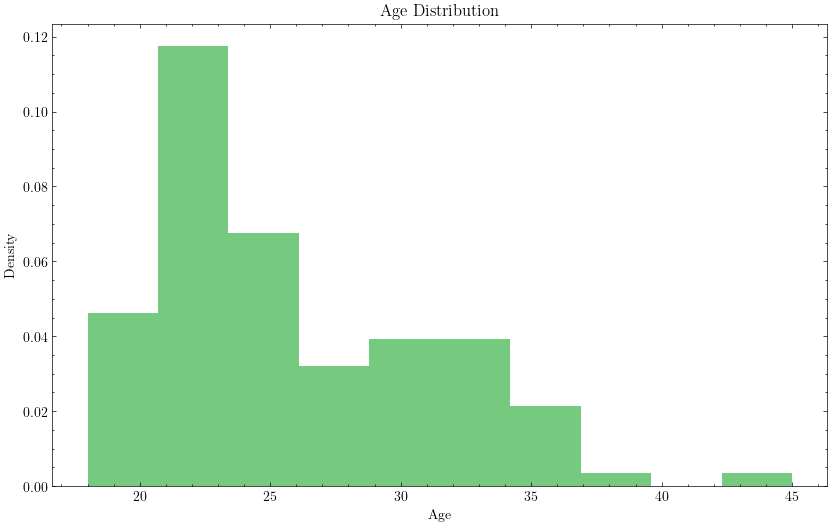

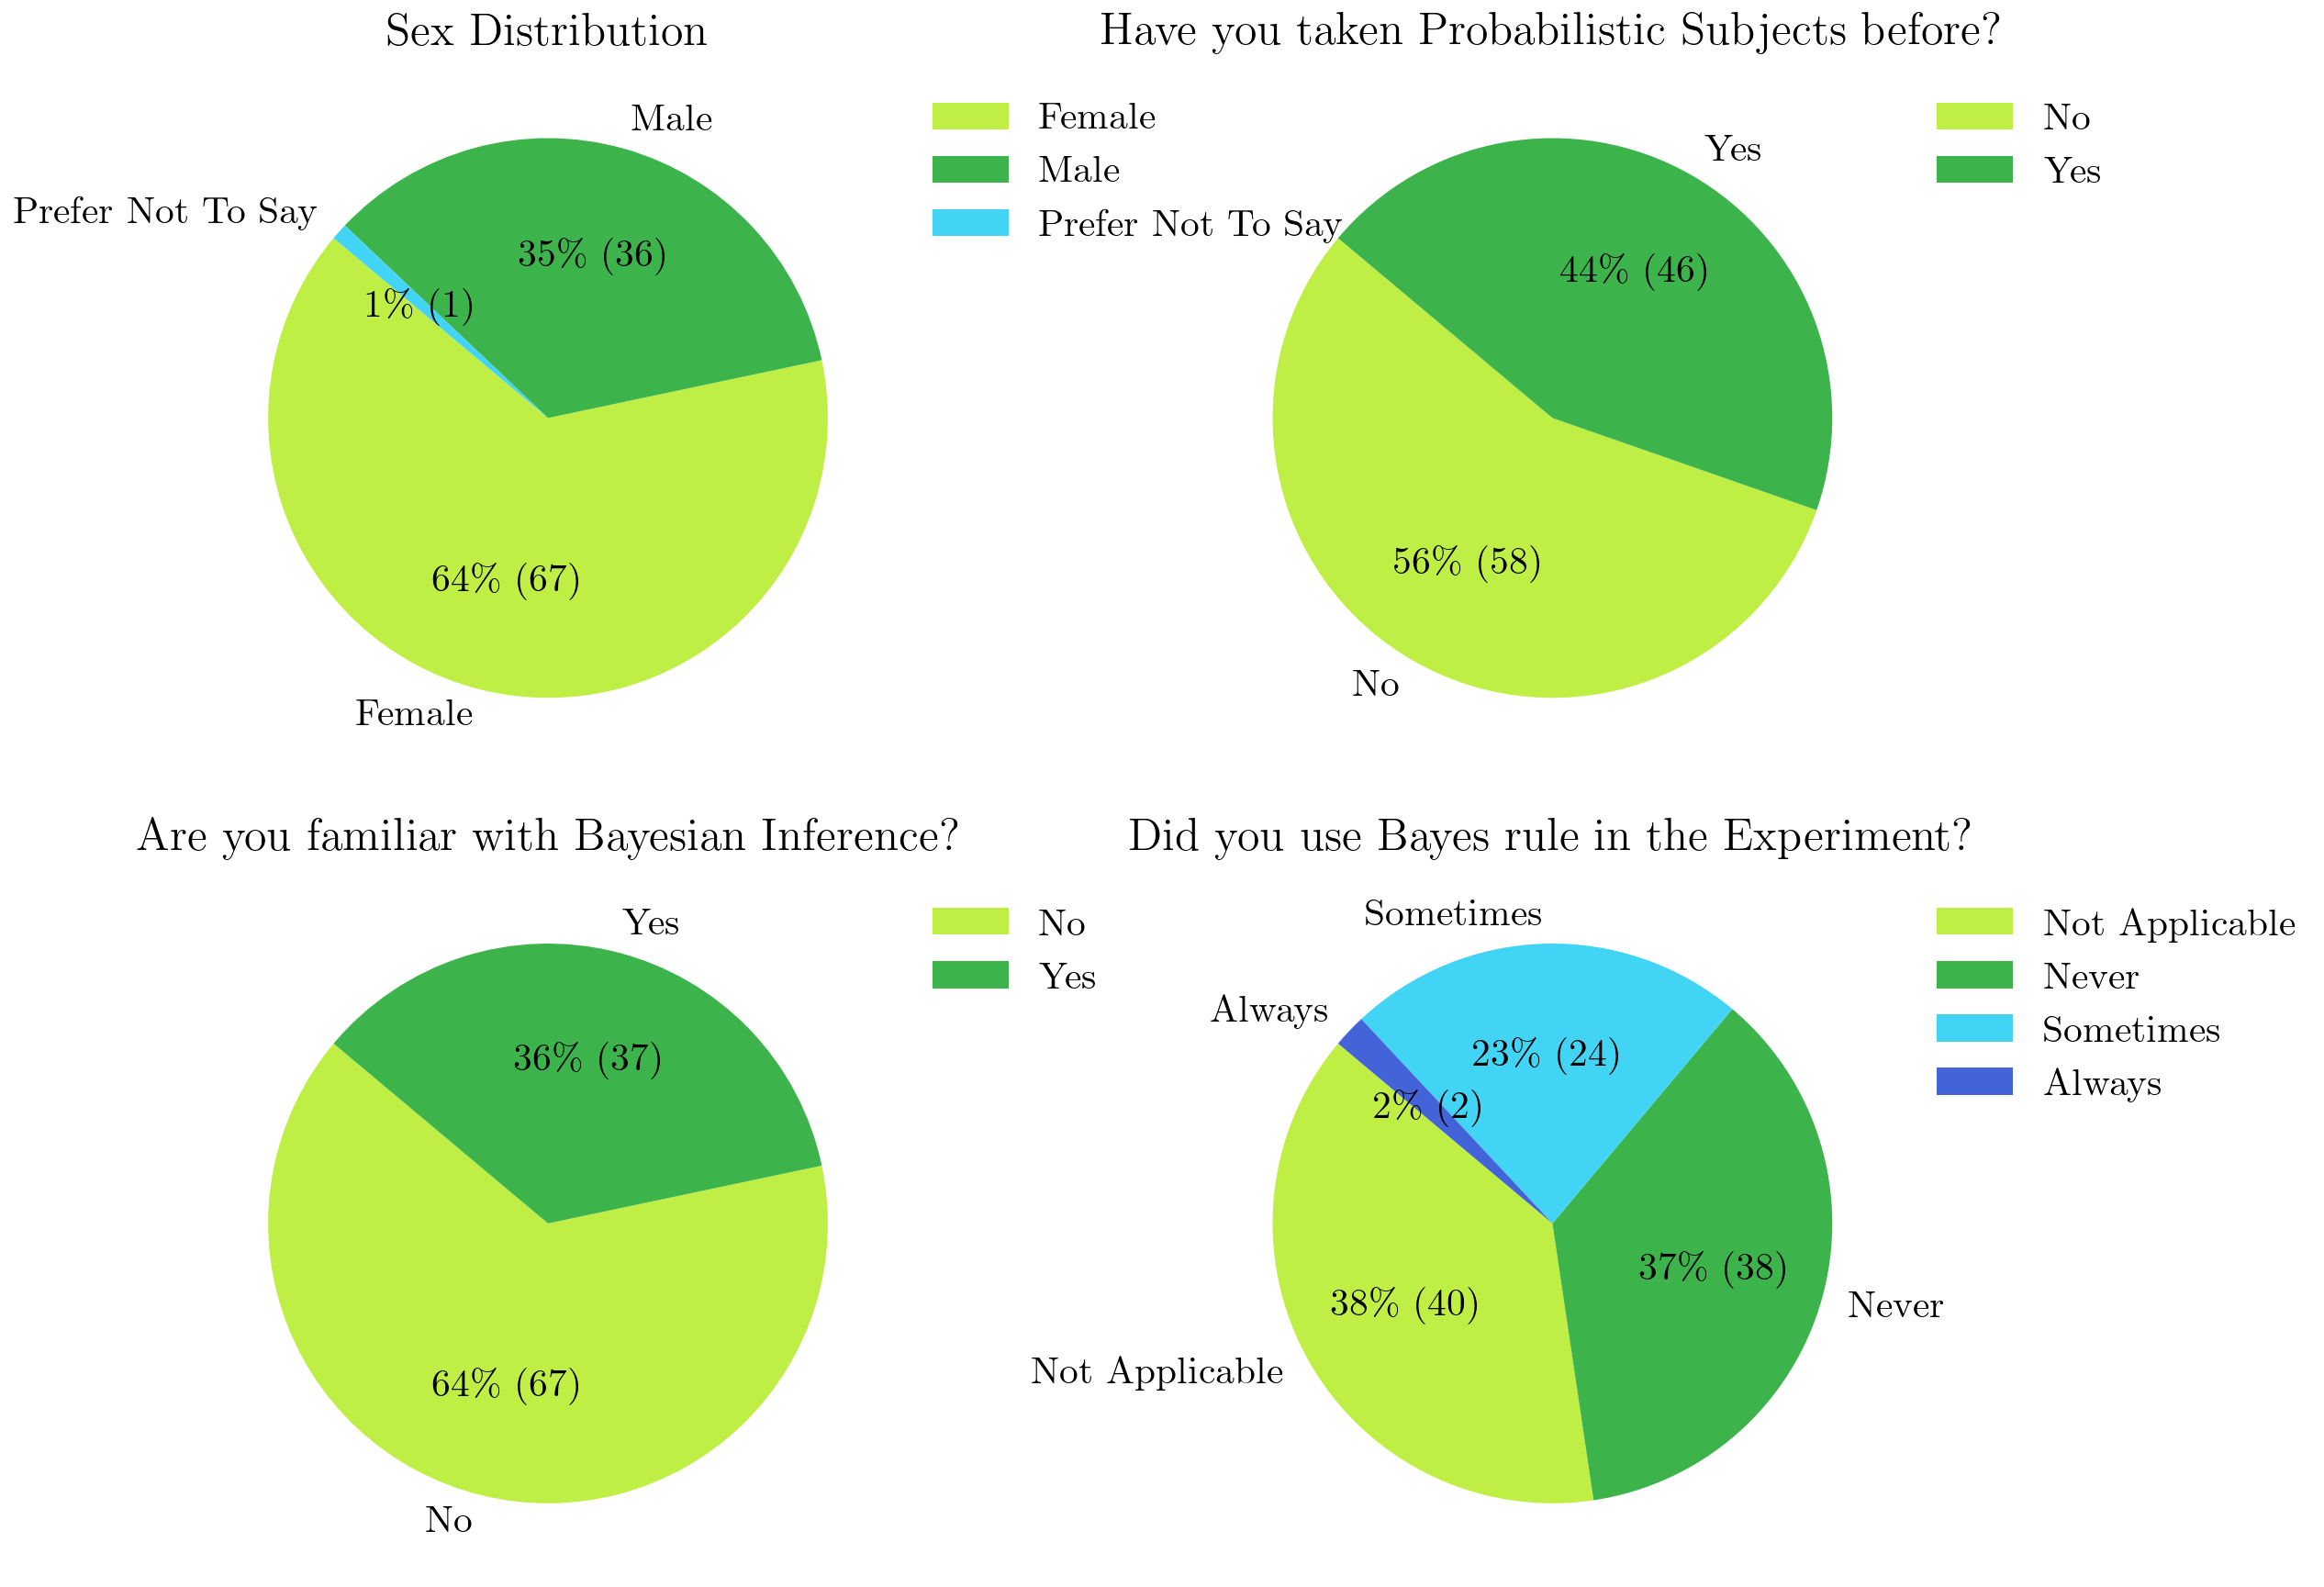

In [83]:
# 'age', 'sex', 'probSubject', 'bayesFamaliar', 'bayesInExp'

display(participant_data.groupby('participantID')['age'].mean().describe())
histogram(participant_data, 'Age Distribution', 'age', 'Age', bins=10)
with plt.style.context("science"):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=300)

    pieChart(participant_data, 'sex', "Sex Distribution", out=False, ax=axes[0, 0])
    pieChart(participant_data, 'probSubject', "Have you taken Probabilistic Subjects before?", out=False, ax=axes[0, 1])
    pieChart(participant_data, 'bayesFamaliar', "Are you familiar with Bayesian Inference?", out=False, ax=axes[1, 0])
    pieChart(participant_data, 'bayesInExp', "Did you use Bayes rule in the Experiment?", out=False, ax=axes[1, 1])
    
    fig.tight_layout()
    plt.savefig("images/demographic_pie.png")     
    plt.show()


### Average Payment Calculation

In [89]:
payment_df_1 = pd.read_csv('Payment/payment_Andy_1to20.csv')
payment_df_2 = pd.read_csv('Payment/payment_Andy_21to42.csv')
payment_df_3 = pd.read_csv('Payment/payment_Andy_43to64.csv')
payment_df_4 = pd.read_csv('Payment/payment_Andy_65to88.csv')
payment_df_5 = pd.read_csv('Payment/payment_Andy_89to103.csv')
payment_df_6 = pd.read_csv('Payment/payment_Andy_104to105.csv')
payment_df_7 = pd.read_csv('Payment/payment_Andy_106to118.csv')
payment_df = pd.concat([payment_df_1, payment_df_2, payment_df_3, payment_df_4, payment_df_5, payment_df_6, payment_df_7], ignore_index=True)
payment_df.describe()

,payment
count,105.00
mean,29.97
std,9.19
min,10.00
25%,23.00
50%,30.00
75%,36.00
max,50.00


## Disaggregate according to Each Ball Draw in Each Instance (Average the Performance of each individual)

In [53]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3'],
      dtype='object')

In [54]:
urnColumns = ['instanceName','seqBall','DQ_U_o', 'urns', 'colours', 'responseTimeUrn','CC_u','DQ_U_o','DQ_U_s','EWCC_u','MDCC_u','ACC_u','AEWCC_u','AMDCC_u'] 

ins_seq_grouped_mean_urn = participant_data[urnColumns].groupby(['instanceName','seqBall']).mean()
ins_seq_grouped_mean_urn

DQ_U_o  urns  colours  responseTimeUrn  CC_u  DQ_U_o  \
instanceName seqBall                                                         
1            1          0.97  2.00     2.00            21.14  5.00    0.97   
             2          0.92  2.00     2.00            27.72 10.00    0.92   
             3          0.93  2.00     2.00            20.66 10.00    0.93   
3            1          0.95  2.00     3.00            36.91  5.00    0.95   
             2          0.83  2.00     3.00            54.36 10.00    0.83   
             3          0.78  2.00     3.00            30.98 10.00    0.78   
5            1          0.97  2.00     4.00            31.13  5.00    0.97   
             2          0.84  2.00     4.00            31.63 10.00    0.84   
             3          0.78  2.00     4.00            20.21 10.00    0.78   
7            1          0.94  3.00     2.00            83.88 10.00    0.94   
             2          0.91  3.00     2.00            59.27 18.00    0.91   
             3          0.86  3.00     2.00            52.76 18.00    0.86   
9            1          0.96  3.00     3.00            32.61 10.00    0.96   
             2          0.79  3.00     3.00            32.52 18.00    0.79   
             3          0.66  3.00     3.00            36.82 18.00    0.66   
11           1          0.95  3.00     4.00            82.01 10.00    0.95   
             2          0.88  3.00     4.00            48.09 18.00    0.88   
             3          0.81  3.00     4.00            35.91 18.00    0.81   
12           1          0.94  3.00     4.00            63.82 10.00    0.94   
             2          0.87  3.00     4.00            44.14 18.00    0.87   
             3          0.81  3.00     4.00            45.71 18.00    0.81   
13           1          0.95  4.00     2.00            81.22 15.00    0.95   
             2          0.87  4.00     2.00            56.74 26.00    0.87   
             3          0.89  4.00     2.00            55.72 26.00    0.89   
15           1          0.92  4.00     3.00           116.77 15.00    0.92   
             2          0.79  4.00     3.00            94.22 26.00    0.79   
             3          0.78  4.00     3.00            61.52 26.00    0.78   
16           1          0.92  4.00     3.00           145.62 15.00    0.92   
             2          0.79  4.00     3.00            81.22 26.00    0.79   
             3          0.73  4.00     3.00            65.51 26.00    0.73   
17           1          0.97  4.00     4.00            48.09 15.00    0.97   
             2          0.85  4.00     4.00            69.15 26.00    0.85   
             3          0.81  4.00     4.00            73.92 26.00    0.81   
18           1          0.96  4.00     4.00            47.53 15.00    0.96   
             2          0.84  4.00     4.00            43.87 26.00    0.84   
             3          0.78  4.00     4.00            40.68 26.00    0.78   

                      DQ_U_s  EWCC_u  MDCC_u  ACC_u  AEWCC_u  AMDCC_u  
instanceName seqBall                                                   
1            1          0.97    3.00    2.00   5.00     3.00     2.00  
             2          0.91    6.00    4.00  15.00     9.00     6.00  
             3          0.88    6.00    4.00  25.00    15.00    10.00  
3            1          0.95    3.00    2.00   5.00     3.00     2.00  
             2          0.85    6.00    4.00  15.00     9.00     6.00  
             3          0.87    6.00    4.00  25.00    15.00    10.00  
5            1          0.97    3.00    2.00   5.00     3.00     2.00  
             2          0.85    6.00    4.00  15.00     9.00     6.00  
             3          0.84    6.00    4.00  25.00    15.00    10.00  
7            1          0.94    6.00    4.00  10.00     6.00     4.00  
             2          0.90   11.00    7.00  28.00    17.00    11.00  
             3          0.85   11.00    7.00  46.00    28.00    18.00  
9            1          0.96    6.00    4.00  10.

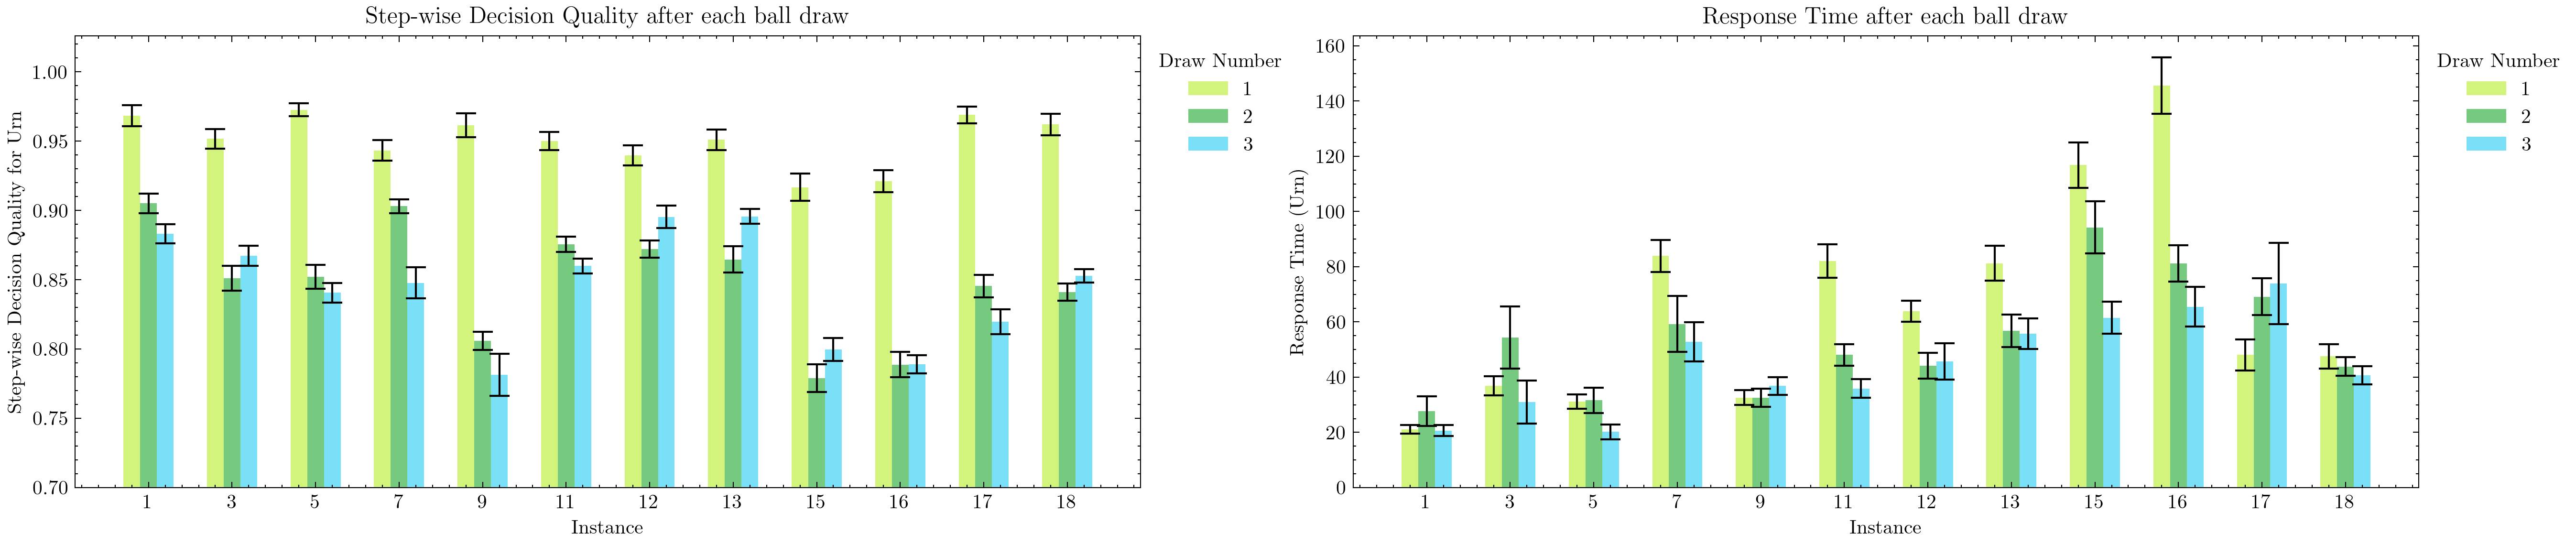

In [55]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(18, 4), dpi=300)
    threeAttributes_bar(df=participant_data, lengend_var='seqBall', legend_title= "Draw Number", y_name='DQ_U_s', y_label='Step-wise Decision Quality for Urn', x_name='instanceName', x_label='Instance', title="Step-wise Decision Quality after each ball draw" , ylimLow=0.7,out=False, ax=axes[0])
    threeAttributes_bar(df=participant_data, lengend_var='seqBall', legend_title= "Draw Number", y_name='responseTimeUrn', y_label='Response Time (Urn)', x_name='instanceName', x_label='Instance', title="Response Time after each ball draw", out=False, ax=axes[1])
    fig.tight_layout()
    plt.savefig("images/ballseq_DQ_RT.png")
    plt.show()

## Disaggregate According to Complexity

### Demographic Bar Graph

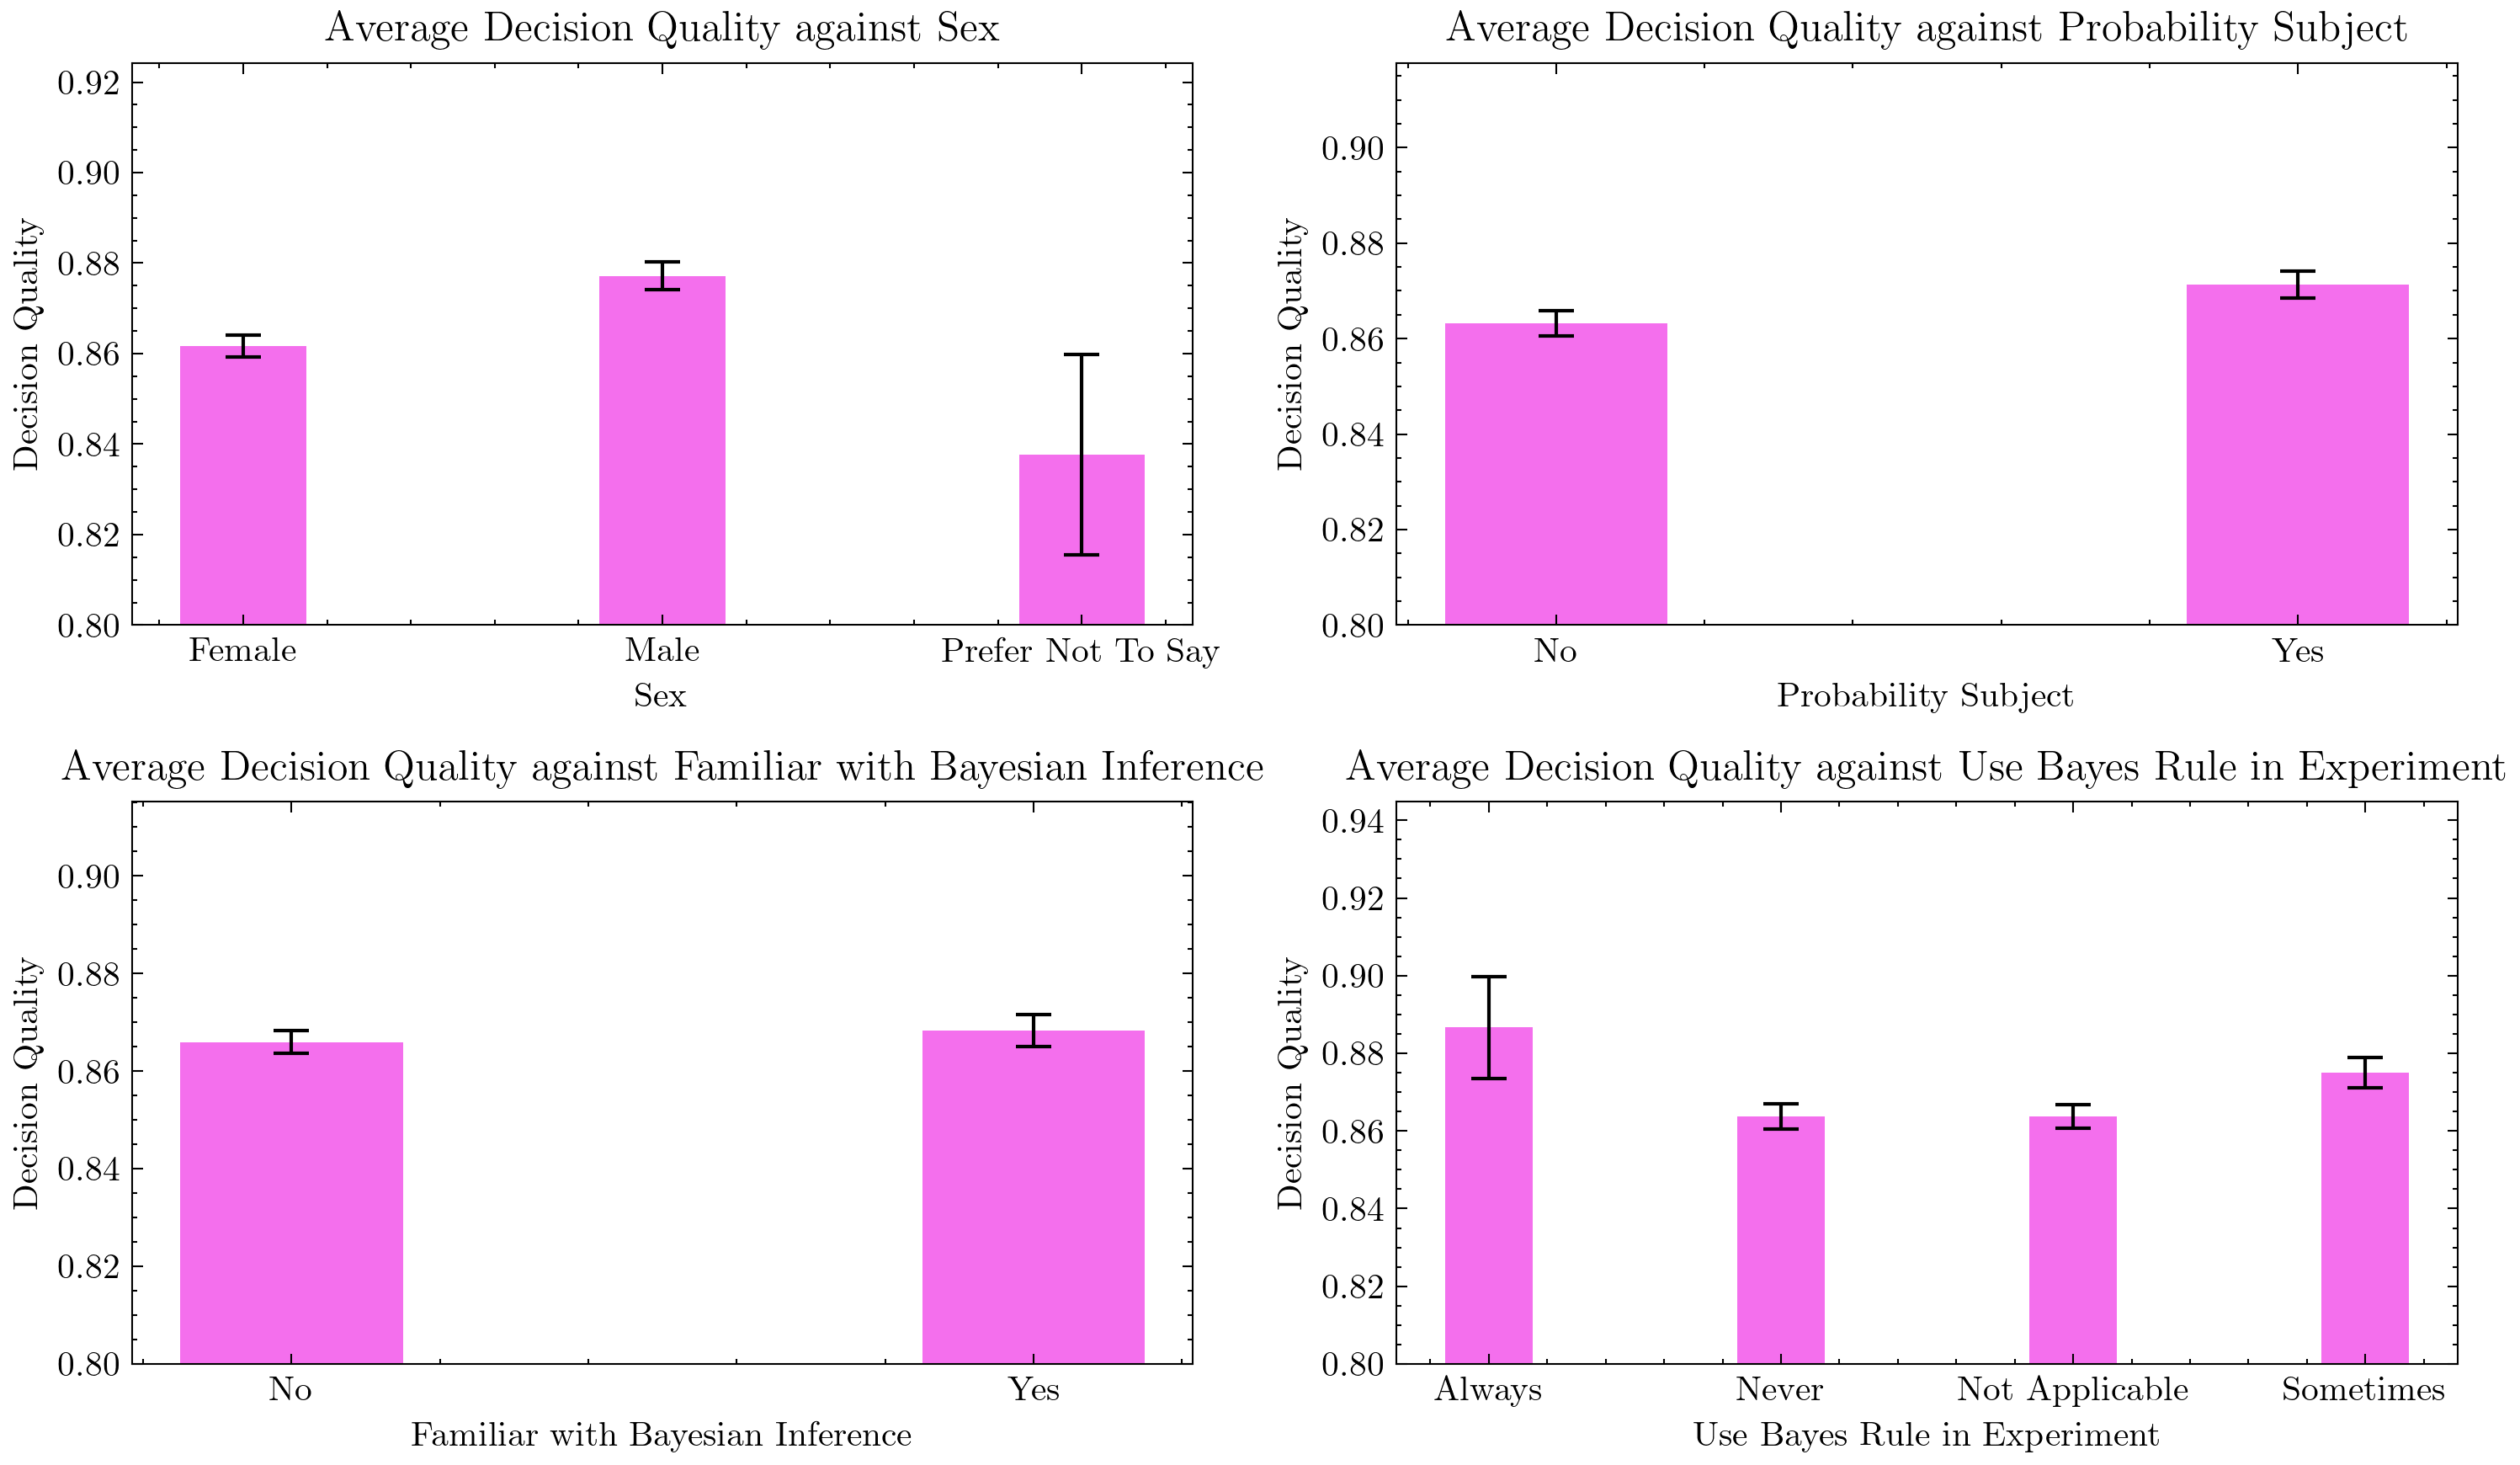

In [56]:
with plt.style.context("science"):
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Decision Quality ', x_name='sex', x_label='Sex',ylimLow=0.8,axes=axes[0, 0])
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Decision Quality ', x_name='probSubject', x_label='Probability Subject',ylimLow=0.8,axes=axes[0, 1])
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Decision Quality ', x_name='bayesFamaliar', x_label='Familiar with Bayesian Inference',ylimLow=0.8,axes=axes[1, 0])
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Decision Quality ', x_name='bayesInExp', x_label='Use Bayes Rule in Experiment',ylimLow=0.8,axes=axes[1, 1])
    fig.tight_layout()
    plt.savefig("images/DQ_Demo_Bar.png")
    plt.show()

### Computational Complexity of each Instance

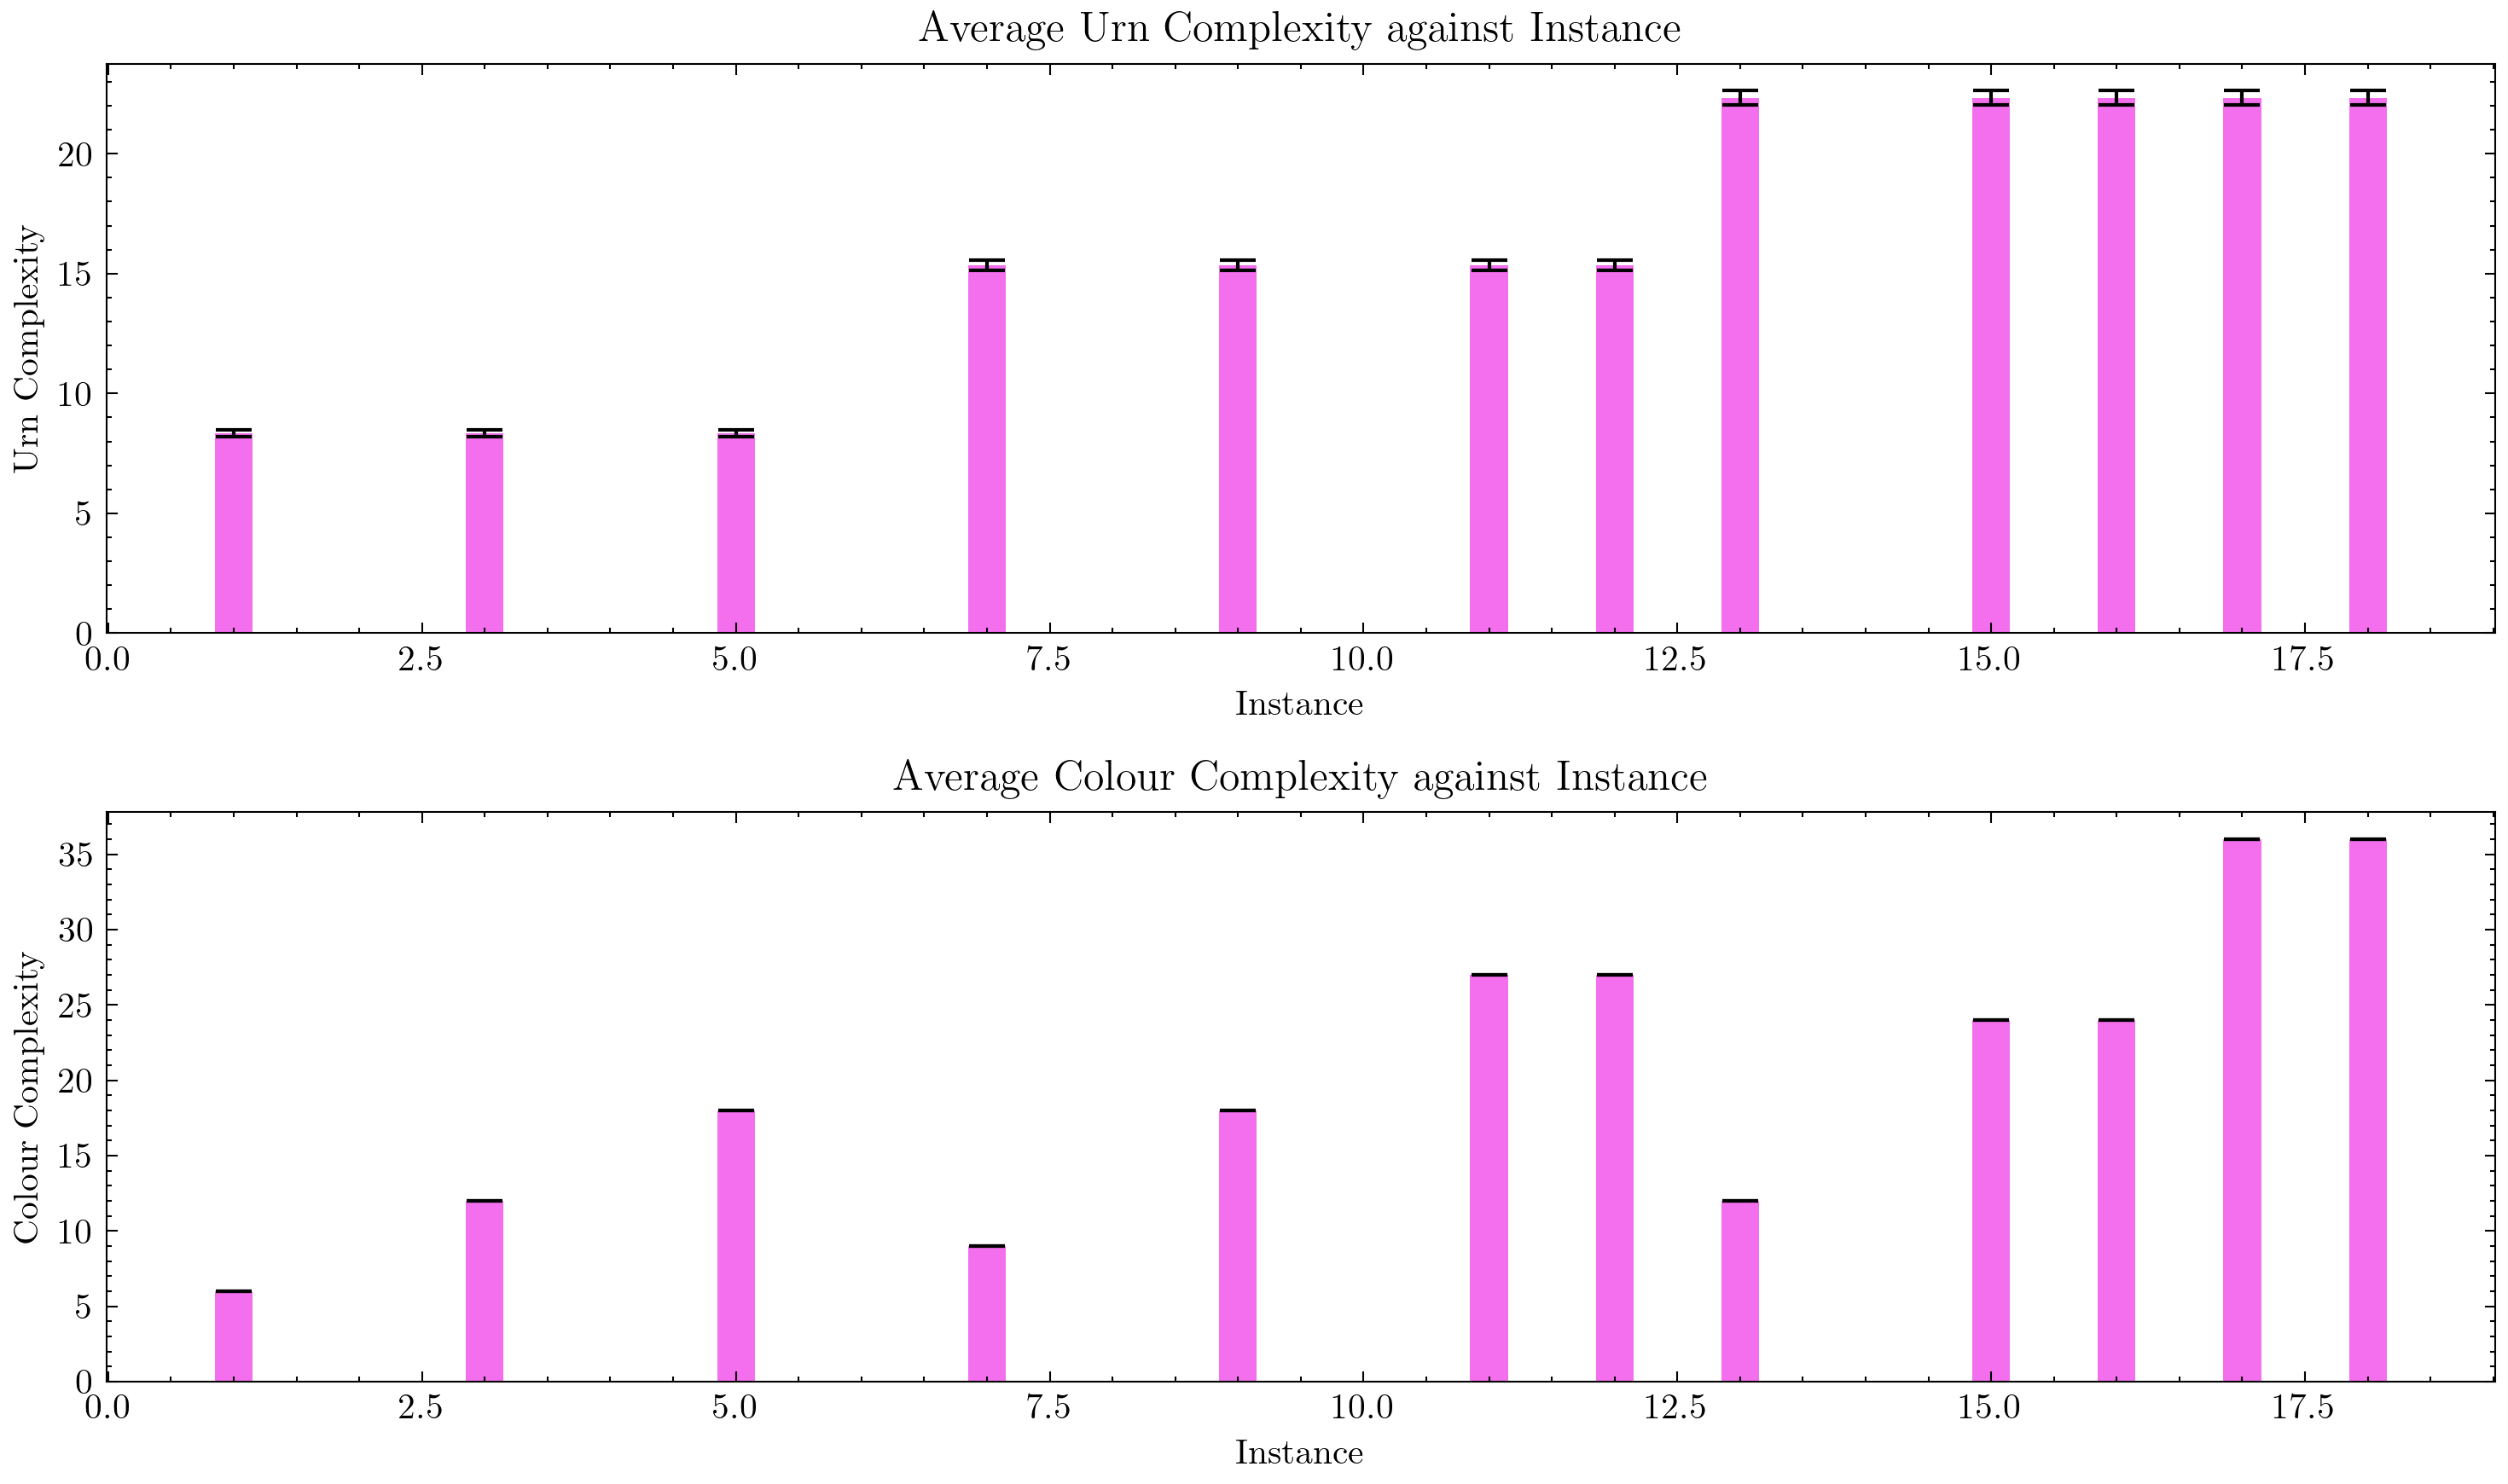

In [57]:
with plt.style.context("science"):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), dpi=300)
    twoAttributes_bar(participant_data, y_name='CC_u', y_label='Urn Complexity ', x_name='instanceName', x_label='Instance', out=False, axes=axes[0])
    twoAttributes_bar(participant_data, y_name='CC_c', y_label='Colour Complexity ', x_name='instanceName', x_label='Instance', out=False,axes=axes[1])
    fig.tight_layout()
    plt.show()


### Decision Quality Vs Complexity

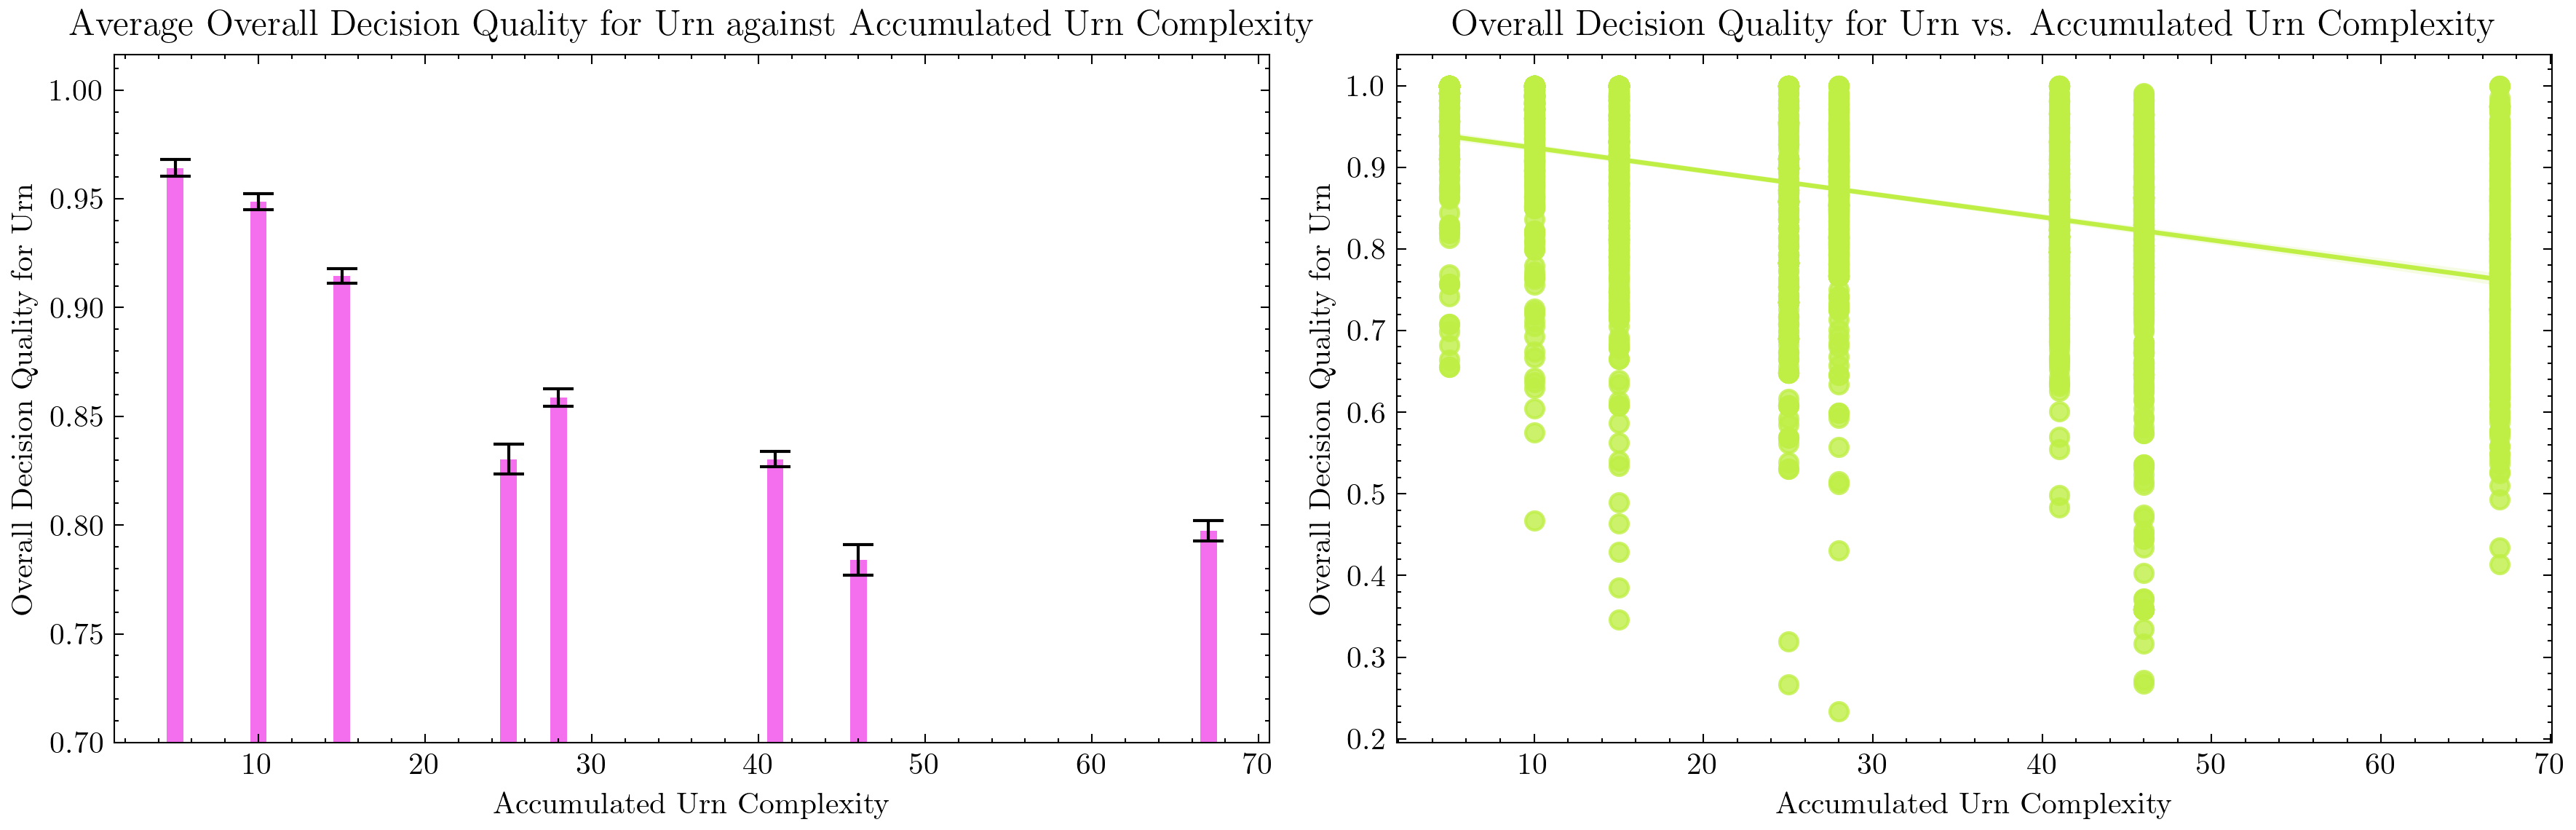

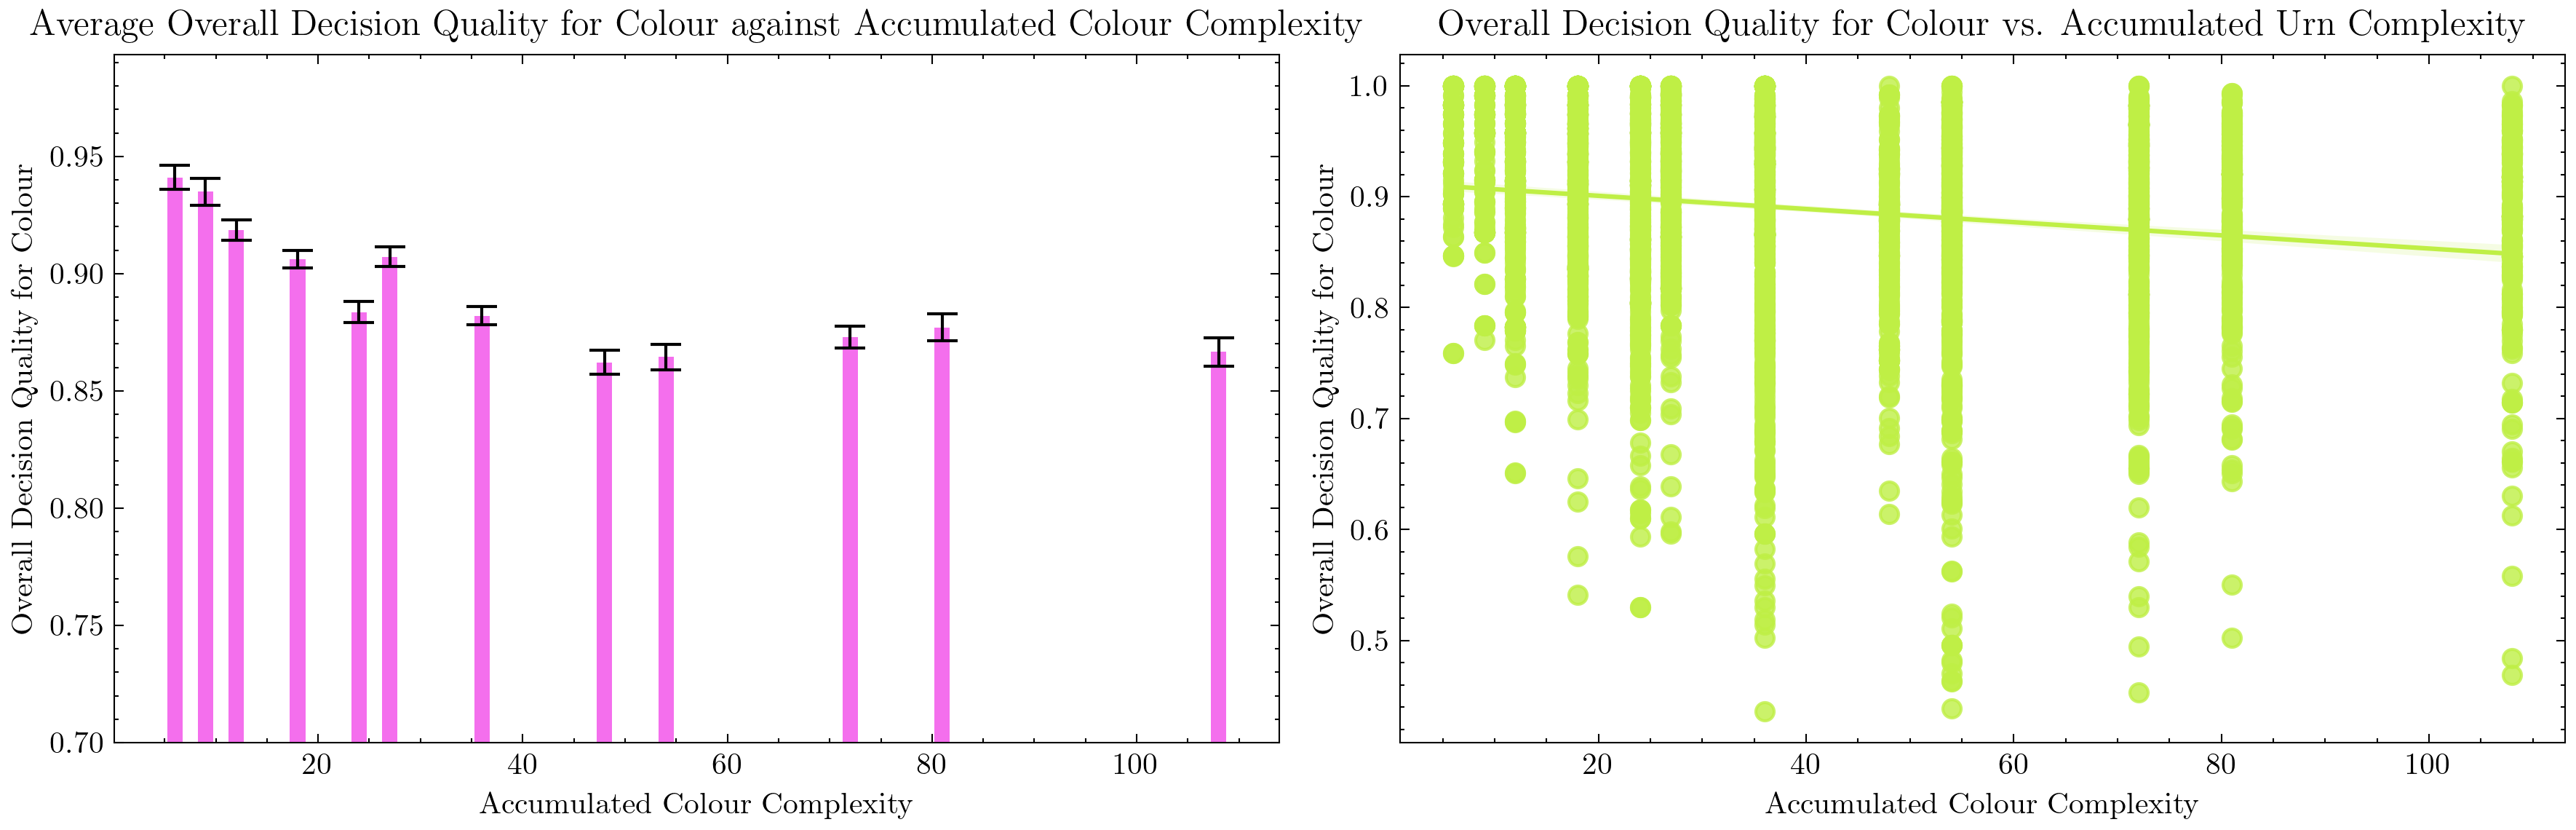

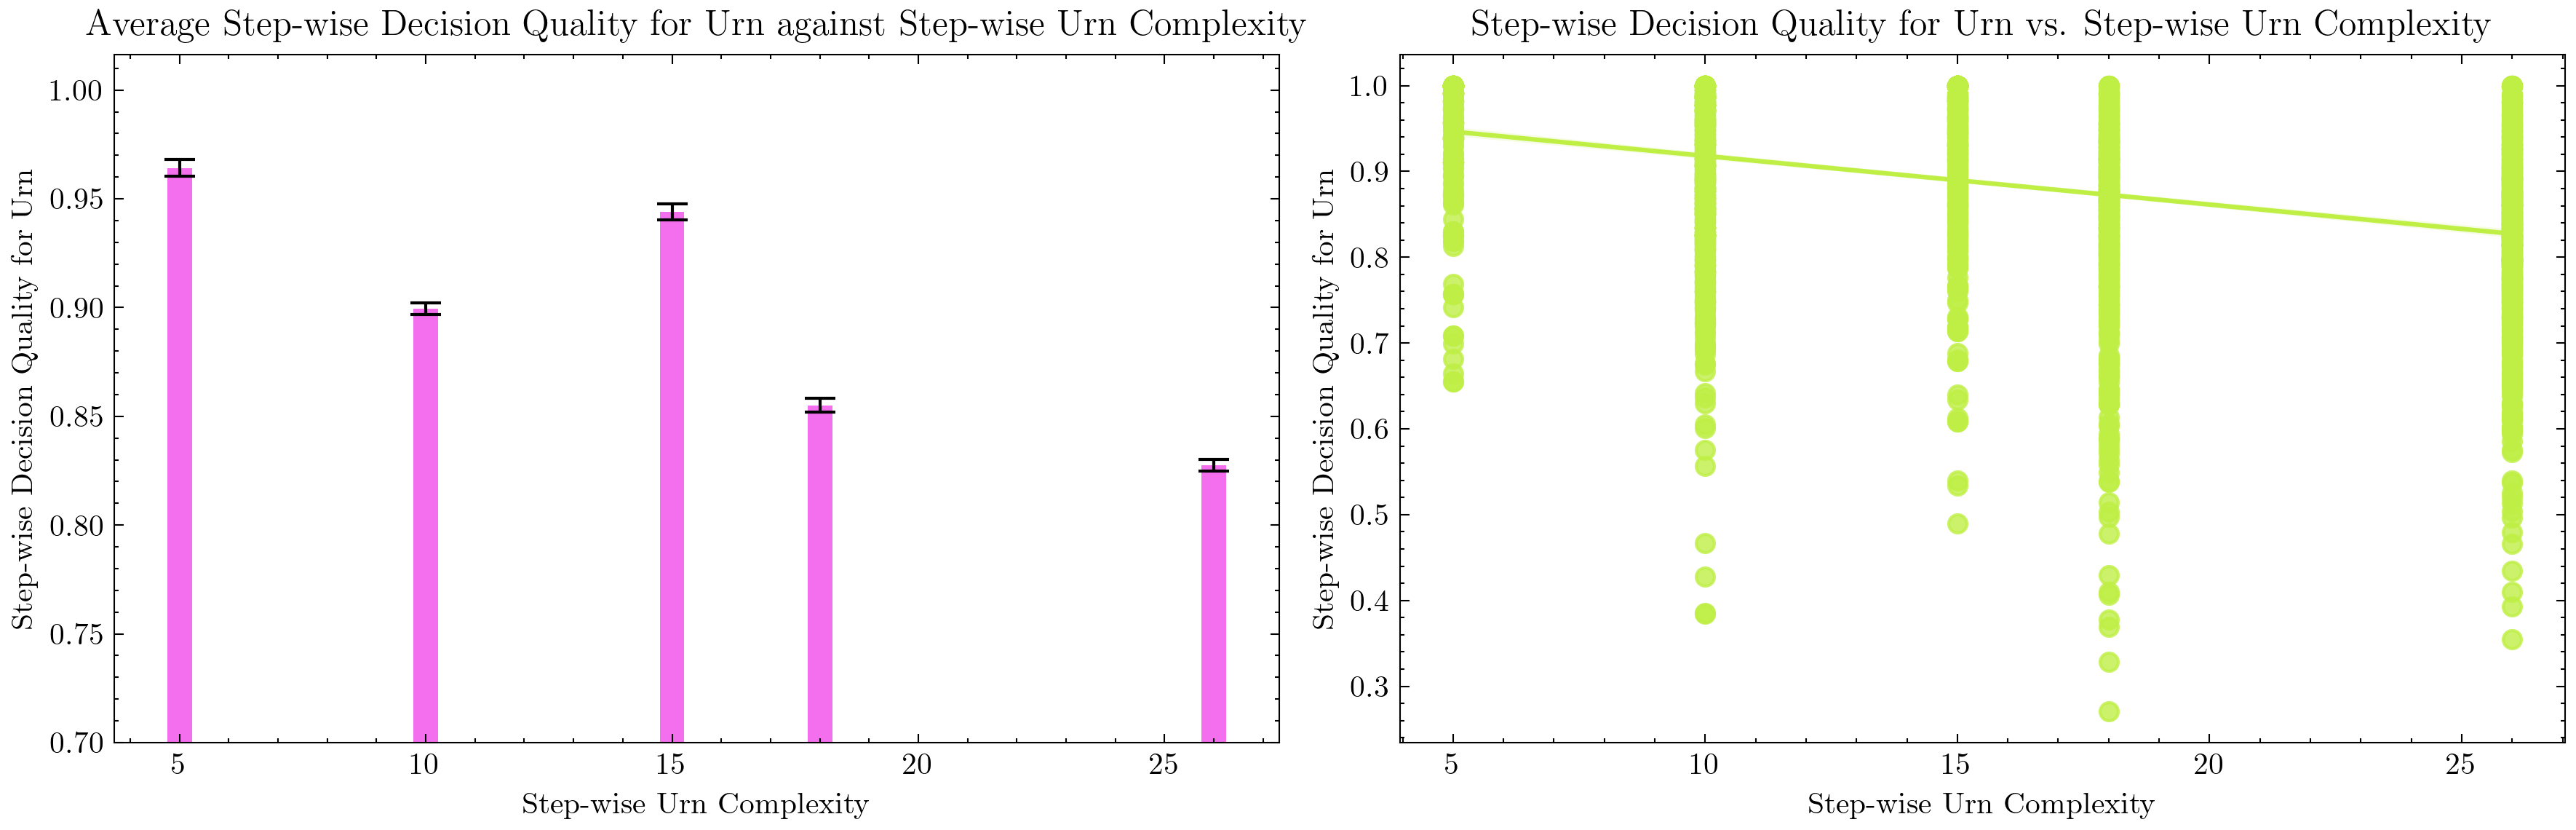

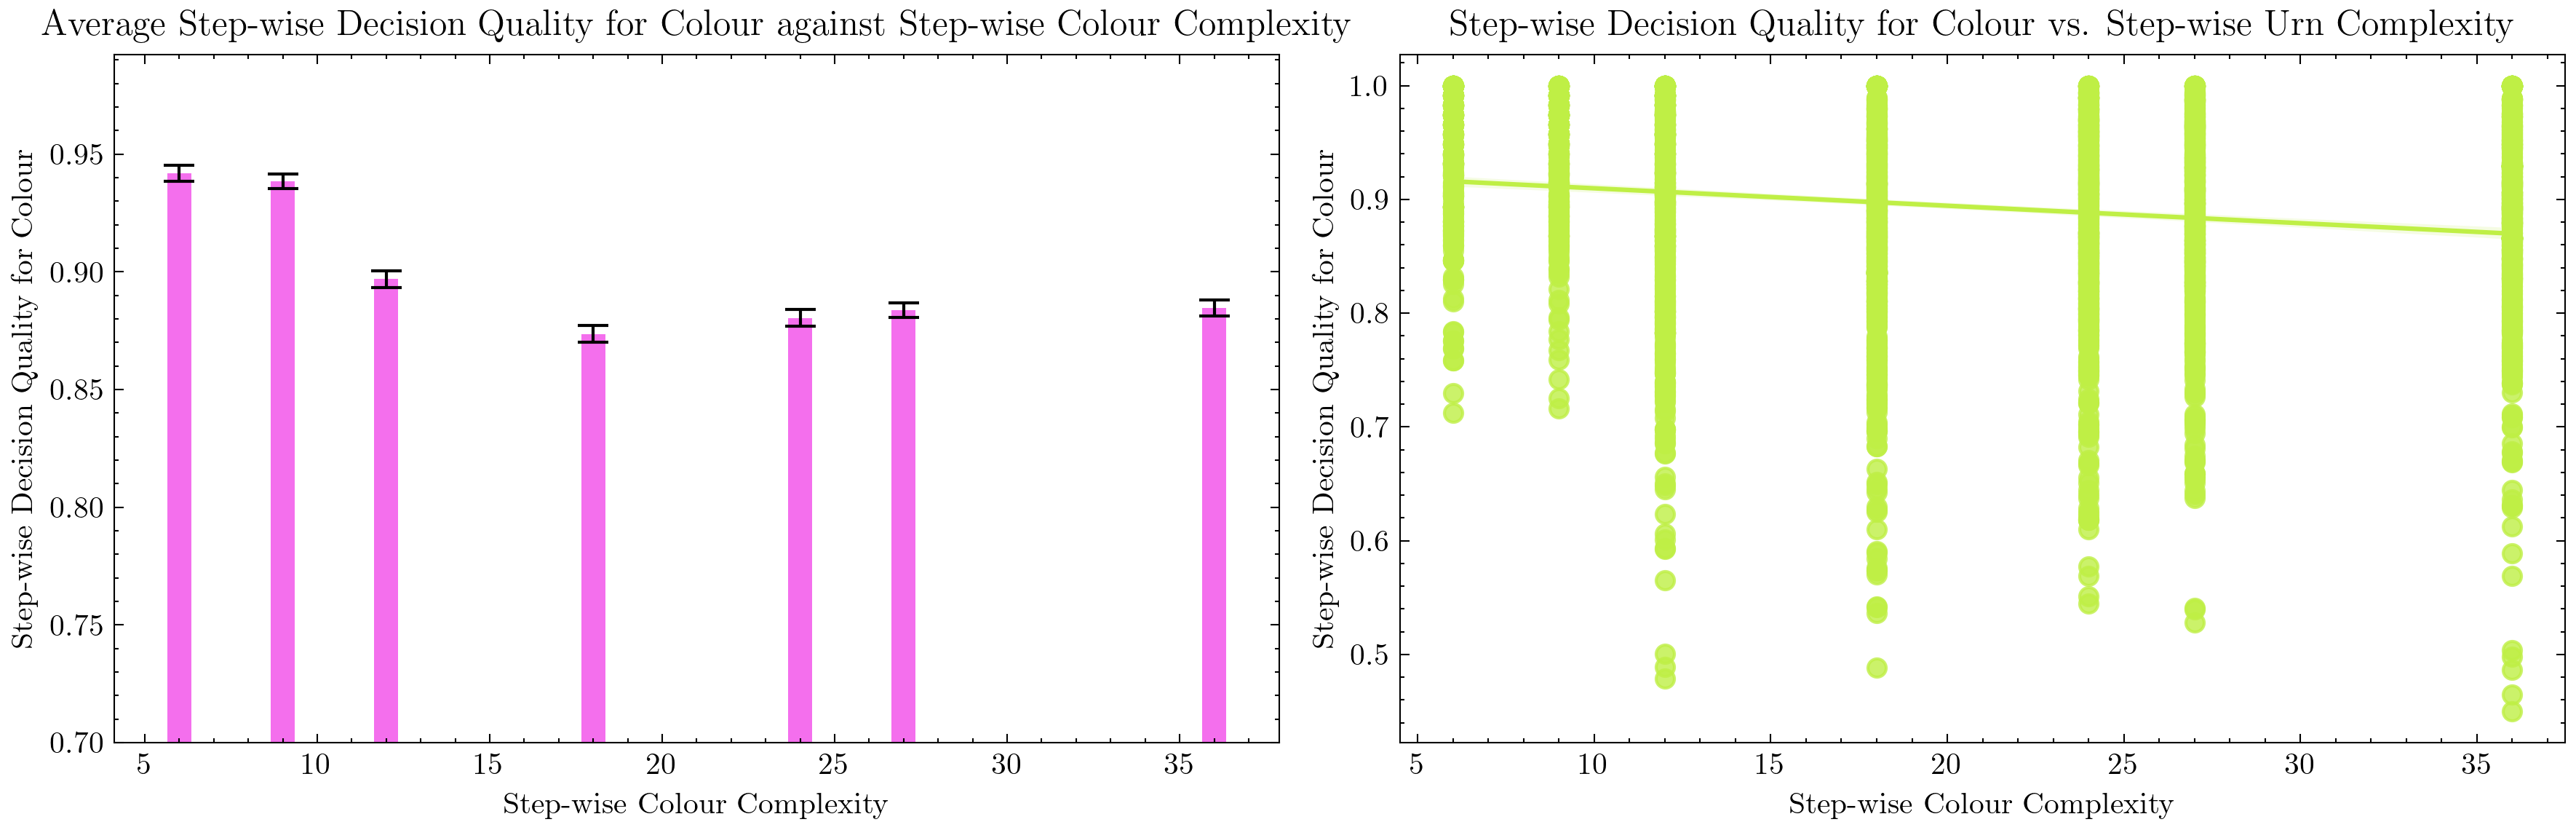

In [58]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Overall Decision Quality for Urn', x_name='ACC_u', x_label='Accumulated Urn Complexity', out=False, axes=axes[0],ylimLow=0.7, bar_width=1)
    regPlot(participant_data, x_name='ACC_u', y_name='DQ_U_o', title='Overall Decision Quality for Urn vs. Accumulated Urn Complexity',axes=axes[1],y_label='Overall Decision Quality for Urn',x_label='Accumulated Urn Complexity')
    fig.tight_layout()
    plt.savefig("images/DQ_ACC_Urn.png")
    plt.show()

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_C_o', y_label='Overall Decision Quality for Colour', x_name='ACC_c', x_label='Accumulated Colour Complexity', out=False, axes=axes[0],ylimLow=0.7, bar_width=1.5)
    regPlot(participant_data, x_name='ACC_c', y_name='DQ_C_o', title='Overall Decision Quality for Colour vs. Accumulated Urn Complexity',y_label='Overall Decision Quality for Colour', x_label='Accumulated Colour Complexity',axes=axes[1])
    fig.tight_layout()
    plt.savefig("images/DQ_ACC_Col.png")
    plt.show()

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_U_s', y_label='Step-wise Decision Quality for Urn', x_name='CC_u', x_label='Step-wise Urn Complexity', out=False,axes=axes[0],ylimLow=0.7, bar_width=0.5)
    regPlot(participant_data, x_name='CC_u', x_label='Step-wise Urn Complexity', y_name='DQ_U_s',y_label='Step-wise Decision Quality for Urn', title='Step-wise Decision Quality for Urn vs. Step-wise Urn Complexity',axes=axes[1])
    fig.tight_layout()
    plt.savefig("images/DQs_CC_Urn.png")
    plt.show()
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_C_s', y_label='Step-wise Decision Quality for Colour', x_name='CC_c', x_label='Step-wise Colour Complexity', out=False, axes=axes[0],ylimLow=0.7, bar_width=0.7)
    regPlot(participant_data, x_name='CC_c',x_label='Step-wise Colour Complexity', y_name='DQ_C_s',y_label='Step-wise Decision Quality for Colour', title='Step-wise Decision Quality for Colour vs. Step-wise Urn Complexity',axes=axes[1])
    fig.tight_layout()
    plt.savefig("images/DQs_CC_Col.png")
    plt.show()

### Response Time Vs Complexity

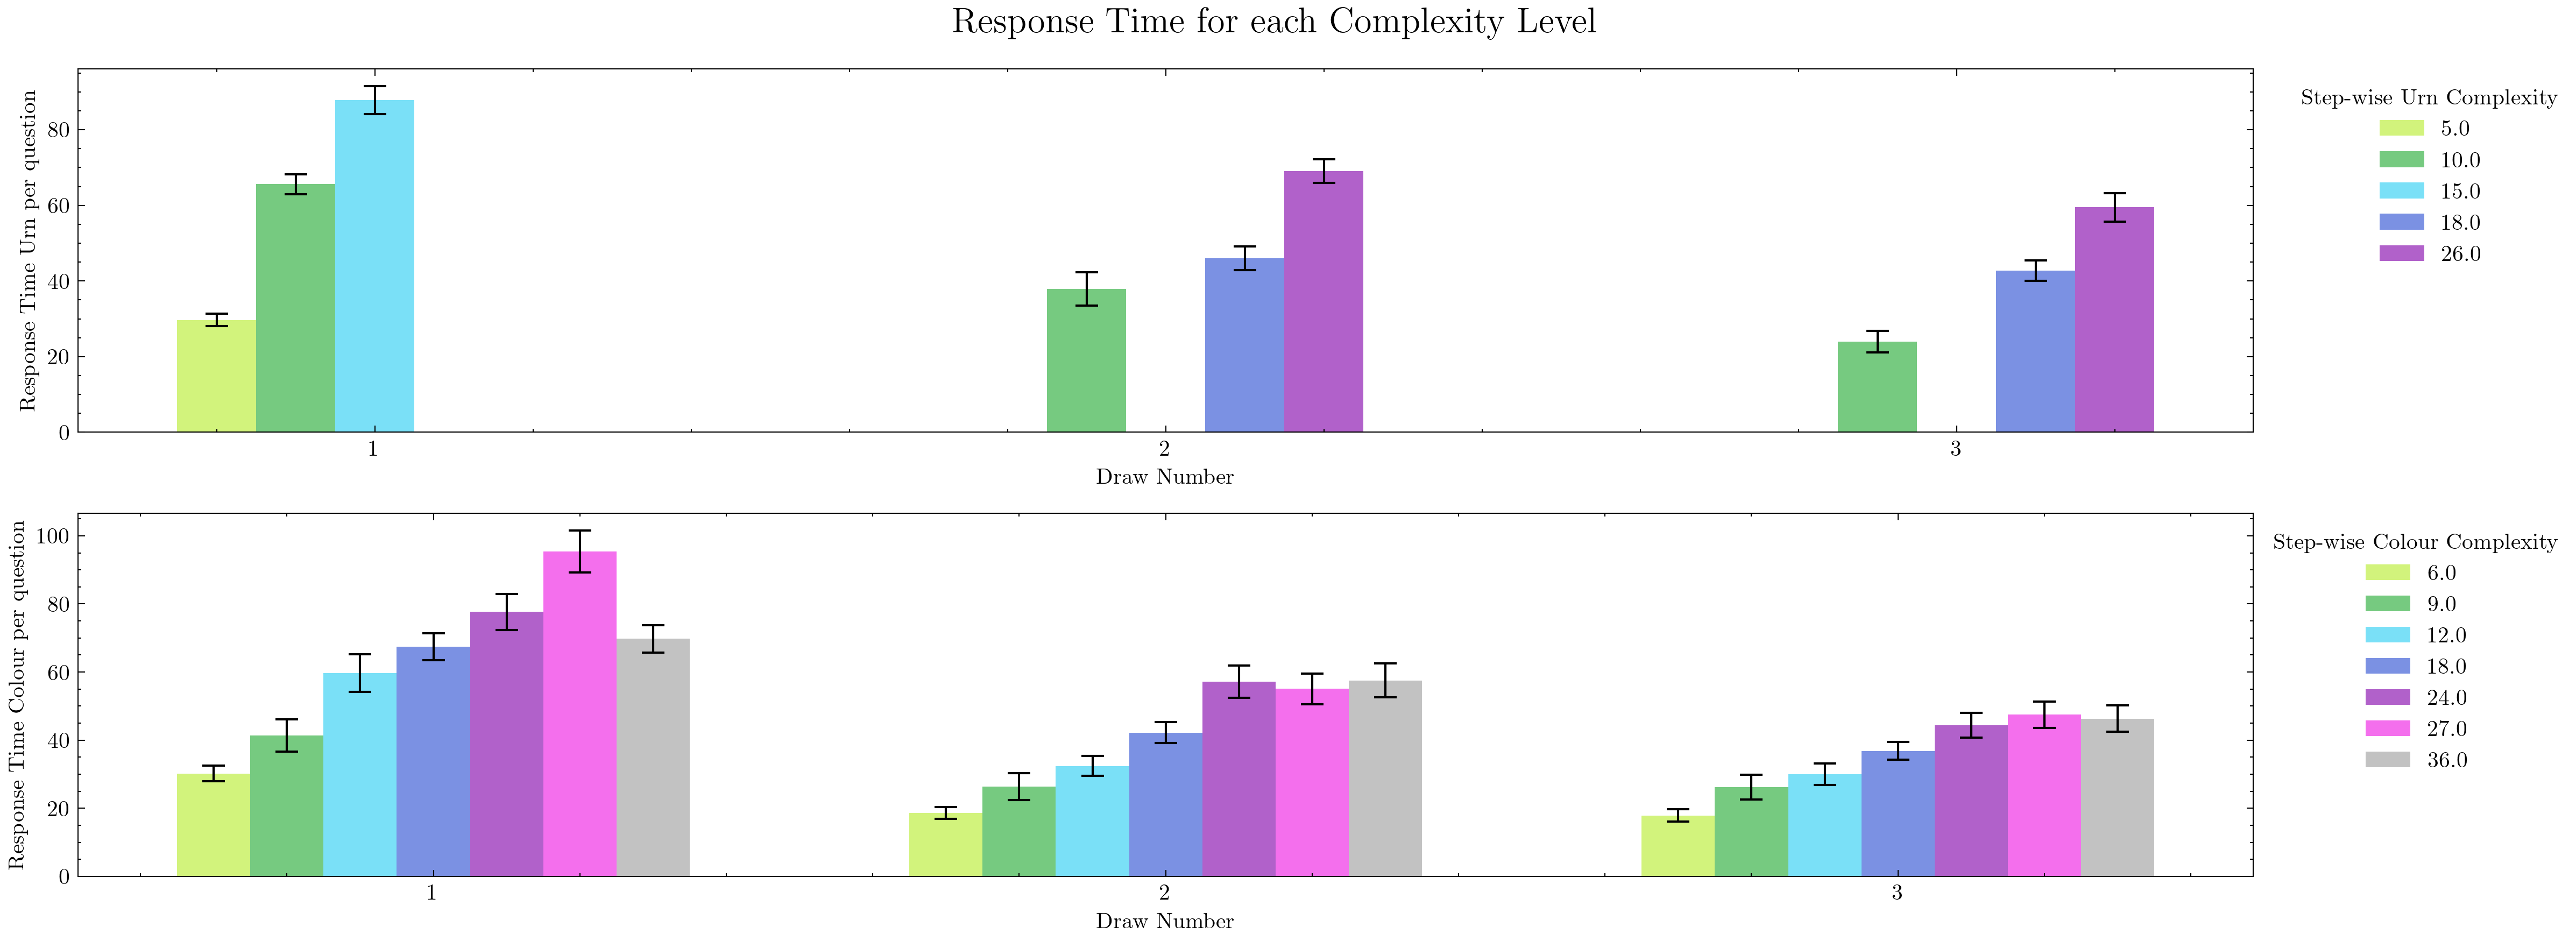

In [59]:
with plt.style.context("science"):
    fig, axes = plt.subplots(2, 1, figsize=(16, 6), dpi=300)
    threeAttributes_bar(participant_data, lengend_var='CC_u', legend_title= "Step-wise Urn Complexity", y_name='responseTimeUrn', y_label='Response Time Urn per question', x_name='seqBall', x_label='Draw Number', bar_width=0.1, out=False, ax=axes[0])
    threeAttributes_bar(participant_data, lengend_var='CC_c', legend_title= "Step-wise Colour Complexity", y_name='responseTimeColour', y_label='Response Time Colour per question', x_name='seqBall', x_label='Draw Number', bar_width=0.1, out=False, ax=axes[1])
    fig.suptitle('Response Time for each Complexity Level', fontsize=16)
    fig.tight_layout()
    plt.savefig("images/RT_CC.png")
    plt.show()


## Pool Urn Decision Quality and Complexity together

In [60]:
# urnColumns = ['participantID', 'instanceName', 'responseTimeUrn', 'DQ_U_o', 'CC_u']
# colColumns = ['participantID', 'instanceName', 'responseTimeColour', 'DQ_C_o', 'CC_c']


# urn_df = participant_data[urnColumns]
# col_df = participant_data[colColumns]

# urn_df['questionType'] = 'Urn'
# col_df['questionType'] = 'Colour'

# urnColumnNameMappings = {'responseTimeUrn': 'responseTime', 
#                          'JSD_Urn': 'JSD',
#                          'urn_complexity_weighted': 'complexityWeighted',
#                          'urn_complexity_MD': 'complexityMD',
#                          'urn_complexity_total': 'complexityTotal'}

# colColumnNameMappings = {'responseTimeColour': 'responseTime',
#                             'JSD_Col': 'JSD',
#                             'col_complexity_weighted': 'complexityWeighted',
#                             'col_complexity_MD': 'complexityMD',
#                             'col_complexity_total': 'complexityTotal'}

# merged_df = pd.concat([urn_df.rename(columns= urnColumnNameMappings), 
#                        col_df.rename(columns= colColumnNameMappings)], 
#                       ignore_index=True)



## Basic Information

In [61]:
# def qualityHistogram(df, title, x_name, x_label):
#     '''
#     Inputs: 
#     df is the input dataframe
#     x_name is the column name of the data to be plotted
#     x_label is the label for the x-axis
#     Ouputs: 
#     Histogram of the data
#     '''
#     with plt.style.context("science"):
#         plt.figure(figsize=(10, 6), dpi=100)
#         plt.hist(df[x_name], bins=10, range=(0,1), color=COLORS[1], edgecolor=COLORS[1], alpha=0.7)
#         plt.title(title)
#         plt.xlabel(x_label)
#         plt.ylabel('Frequency')
#         plt.xlim(0, 1)
#         plt.show()



In [62]:
# qualityHistogram(participant_data, 'Histogram of JSD Urn', 'DQ_U_o', 'Decision Quality Urn')
# qualityHistogram(participant_data, 'Histogram of JSD Col', 'DQ_C_o', 'Decision Quality Colour')


# Regressions

## Bayesian Regressions

### H1-B In the state updating question, decision quality does not decrease as the number of potential signals (number of possible colors) in an instance increase, since more potential signals does not increase computational complexity.

In [63]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3'],
      dtype='object')

### H2-C In state updating task, step-wise decision quality for the third ball draw is no lower than for the second ball draw, as the belief updating process of the third and second draws have the same computational complexity.

### H4 In signal prediction task, the step-wise decision quality for the third ball draw is no lower than for the second ball draw and the first ball draw, as the belief updating process of the third draw has the same computational complexity with for the second draw and the first ball draw.

### H1 In the question regarding the hidden state of the world (the state updating task), decision quality is predicted to be negatively correlated with computational complexity.

### H2 In state updating task, step-wise decision quality (decision quality taking into account participants previous answers as priors of the next updating) is negatively correlated with step-wise computational complexity.

## Frequentist Models

In [64]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3'],
      dtype='object')

In [65]:
# R1
model = mixedlm("DQ_U_o ~ ACC_u", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_U_o   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0097   
Min. group size:  36      Log-Likelihood:     3278.5384
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.952    0.004 230.742 0.000  0.944  0.960
ACC_u       -0.003    0.000 -34.451 0.000 -0.003 -0.003
Group Var    0.001    0.002                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [66]:
# R2
model = mixedlm("DQ_C_o ~ ACC_c", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_C_o   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0059   
Min. group size:  36      Log-Likelihood:     4156.5355
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.913    0.005 183.286 0.000  0.903  0.922
ACC_c       -0.001    0.000 -12.628 0.000 -0.001 -0.001
Group Var    0.002    0.004                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [67]:
# R3
model = mixedlm("DQ_U_o ~ urns + colours + seqBall", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_U_o   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0087   
Min. group size:  36      Log-Likelihood:     3460.4718
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    1.107    0.010 115.134 0.000  1.088  1.125
urns        -0.013    0.002  -6.624 0.000 -0.016 -0.009
colours     -0.016    0.002  -8.236 0.000 -0.020 -0.012
seqBall     -0.075    0.002 -39.917 0.000 -0.078 -0.071
Group Var    0.001    0.002                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [68]:
# R4
model = mixedlm("DQ_C_o ~ urns + colours + seqBall", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_C_o   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0058   
Min. group size:  36      Log-Likelihood:     4186.3137
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.976    0.009 112.991 0.000  0.959  0.993
urns         0.000    0.002   0.103 0.918 -0.003  0.003
colours     -0.022    0.002 -13.851 0.000 -0.025 -0.019
seqBall     -0.010    0.002  -6.717 0.000 -0.013 -0.007
Group Var    0.002    0.004                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [69]:
# R5
model = mixedlm("DQ_U_s ~ CC_u", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_U_s   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0075   
Min. group size:  36      Log-Likelihood:     3754.9737
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.975    0.005 213.255 0.000  0.966  0.984
CC_u        -0.006    0.000 -27.939 0.000 -0.006 -0.005
Group Var    0.001    0.002                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [70]:
# R6
model = mixedlm("DQ_C_s ~ CC_c", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_C_s   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0048   
Min. group size:  36      Log-Likelihood:     4538.7780
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.925    0.005 172.360 0.000  0.915  0.936
CC_c        -0.002    0.000 -12.955 0.000 -0.002 -0.001
Group Var    0.002    0.005                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [71]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3'],
      dtype='object')

In [72]:
# R7
model = mixedlm("DQ_U_o ~ probSubject + bayesInExp", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      DQ_U_o   
No. Observations:       3744         Method:                  REML     
No. Groups:             104          Scale:                   0.0129   
Min. group size:        36           Log-Likelihood:          2760.2354
Max. group size:        36           Converged:               Yes      
Mean group size:        36.0                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.884    0.024 36.577 0.000  0.837  0.931
probSubject[T.Yes]            0.005    0.007  0.703 0.482 -0.009  0.020
bayesInExp[T.Never]          -0.023    0.025 -0.928 0.354 -0.071  0.025
bayesInExp[T.Not Applicable] -0.022    0.025 -0.876 0.381 -0.070  0.027
bayesInEx

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [73]:
# R8
model = mixedlm("DQ_C_o ~ probSubject + bayesInExp", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      DQ_C_o   
No. Observations:      3744         Method:                  REML     
No. Groups:            104          Scale:                   0.0061   
Min. group size:       36           Log-Likelihood:          4080.2033
Max. group size:       36           Converged:               Yes      
Mean group size:       36.0                                           
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.865    0.032 26.967 0.000  0.802  0.928
probSubject[T.Yes]           0.002    0.010  0.242 0.809 -0.017  0.022
bayesInExp[T.Never]          0.005    0.033  0.141 0.888 -0.059  0.068
bayesInExp[T.Not Applicable] 0.025    0.033  0.779 0.436 -0.038  0.089
bayesInExp[T.Sometimes]

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [74]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3'],
      dtype='object')

In [75]:
# R9
model = mixedlm("DQ_U_s ~ DV_seqBall_1 + DV_seqBall_3", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: DQ_U_s   
No. Observations:  3744    Method:             REML     
No. Groups:        104     Scale:              0.0066   
Min. group size:   36      Log-Likelihood:     3977.8771
Max. group size:   36      Converged:          Yes      
Mean group size:   36.0                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.849    0.004 233.356 0.000  0.842  0.856
DV_seqBall_1  0.102    0.003  31.285 0.000  0.096  0.108
DV_seqBall_3 -0.004    0.003  -1.311 0.190 -0.011  0.002
Group Var     0.001    0.002                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [76]:
# R10
model = mixedlm("DQ_U_s ~ DV_seqBall_2 + DV_seqBall_3", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: DQ_U_s   
No. Observations:  3744    Method:             REML     
No. Groups:        104     Scale:              0.0066   
Min. group size:   36      Log-Likelihood:     3977.8771
Max. group size:   36      Converged:          Yes      
Mean group size:   36.0                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.951    0.004 261.385 0.000  0.943  0.958
DV_seqBall_2 -0.102    0.003 -31.285 0.000 -0.108 -0.096
DV_seqBall_3 -0.106    0.003 -32.597 0.000 -0.113 -0.100
Group Var     0.001    0.002                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Other Things

In [77]:
import time

start_time = time.time()
for i in range(100000000):
    result = 0.25 * 0.33
end_time = time.time()

time_consumed = end_time - start_time
print(f"Time consumed for calculating: {time_consumed} seconds")

Time consumed for calculating: 2.4207470417022705 seconds


In [78]:
import time

start_time = time.time()
result = 0
for i in range(100000000):
    result = 0.25 + 0.33
end_time = time.time()

time_consumed = end_time - start_time
print(f"Time consumed for calculating: {time_consumed} seconds")

Time consumed for calculating: 2.3711109161376953 seconds
